In [1]:
# =============================================================================
# Code block 1 - Requirements
# =============================================================================


# We start by importing required modules
# File structure
import os
import subprocess
import csv
from collections import Counter

# Pandas
import pandas as pd
import numpy as np
import networkx as nx
# These are the fundamental modules used for analysing the data


# Pictures
import matplotlib.pyplot as plt
import seaborn as sns

# Sequence manipulation
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
# These modules are priarily used for loading the database, and then for identifying whether there are any
# Perfrect protein matches in the dataset

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Other general
from tqdm import tnrange, tqdm_notebook
# We just import this to check our code runs sensibly and to get timing estimates for stuff
from copy import deepcopy

#Looking at local files
%ls 



ariba_output/
ariba_output.tar.gz
flex1_output/
flex_correct.csv
flex_outputs.tar.gz
main_analysis_April2023.ipynb
meta_data_apr2023.csv
readymade_resfinder_20191001_full_sim_matrix.csv
resfinderfull_20191001_names.csv
result_tarballs/


In [2]:
# =============================================================================
# Code Section 1 - Explaining isolate AST data (meta_data)
# =============================================================================

# To begin with before getting into the genetic code, we start with the meta data, this includes AST results and source

# This is all in file meta_data.csv
# This includes the source dataset, and the phenotypes (Raw values + interpreted according to E coff and EUCAST clinical breakpoint)
# Of note, aside from the animal and plant health dataset, all samples have guuids which are available on the SRA (labelled as the external ID)

meta_data = pd.read_csv("meta_data_apr2023.csv")
guuids = sorted(list(set(list(meta_data.guuid))))
print("Number of samples: {0}" .format(len(guuids)))
print("Number of AST tests: {0}" .format(len(meta_data)))

# Note guuid and antibiotic uniquely determines each line
assert len(list(set(meta_data.guuid_antibioic))) ==  len(meta_data)

# Now checking the numbers part of each set
source = {"APHA":[], # The (commensal) isolates donated from the Animal and Plant health Agengy, UK => Surveilance isolates from pig farms across england) 
         "HICF":[],  # The (pathogenic) isolates donated from Public Health England, UK => Isolates from a reference laboratory with rare/unusual phenotypes
         "OXFORD": [] # The(pathogenic) isolates identified sequentially from a microbiology laboratory in a UK tertiary centre}
         }
for k in guuids:
    k_source = list(meta_data.loc[k==meta_data.guuid].source)
    assert len(set(k_source)) == 1
    source[k_source[0]].append(k)

print("Source")
for k in source:
    print(k, ":", len(source[k]), "isolates")

meta_data.head()





Number of samples: 1818
Number of AST tests: 12217
Source
APHA : 497 isolates
HICF : 337 isolates
OXFORD : 984 isolates


,guuid_antibioic,method,antibiotic_rawname,raw_result,inferred_mic,eucast_interpretation,clsi_interpretation,ecoff_interpretation,guuid,id,source,antibiotic_name,abx_type,abx_subtype,tot_no_tests
0,00061137-91ba-470f-aa2f-181b487df07d:ampicillin,bd_phoenix,Ampicillin,>8,16.0,R,I,R,00061137-91ba-470f-aa2f-181b487df07d,HICF818,HICF,ampicillin,beta-lactam,penicillin_3g,2
1,00061137-91ba-470f-aa2f-181b487df07d:ceftazidime,bd_phoenix,Ceftazidime,>8,16.0,R,R,R,00061137-91ba-470f-aa2f-181b487df07d,HICF818,HICF,ceftazidime,beta-lactam,cephalosporin_3g,2
2,00061137-91ba-470f-aa2f-181b487df07d:ceftriaxone,bd_phoenix,Ceftriaxone,>4,8.0,R,R,R,00061137-91ba-470f-aa2f-181b487df07d,HICF818,HICF,ceftriaxone,beta-lactam,cephalosporin_3g,2
3,00061137-91ba-470f-aa2f-181b487df07d:cipriflox...,bd_phoenix,Ciprofloxacin,0.25,1.0,S,S,R,00061137-91ba-470f-aa2f-181b487df07d,HICF818,HICF,ciprifloxacin,fluoroquinolone,NaN,2
4,00061137-91ba-470f-aa2f-181b487df07d:gentamicin,bd_phoenix,Gentamicin,<=1,1.0,S,S,S,00061137-91ba-470f-aa2f-181b487df07d,HICF818,HICF,gentamicin,aminoglycoside,NaN,2


['ampicillin', 'cefotaxime', 'ceftazidime', 'ceftriaxone', 'ciprifloxacin', 'gentamicin', 'meropenem', 'trimethoprim-sulfamethoxazole']
ampicillin
R    1090
S     725
Name: eucast_interpretation, dtype: int64
ceftriaxone
S    1171
R     146
I       4
Name: eucast_interpretation, dtype: int64
cefotaxime
S    461
R     25
I     11
Name: eucast_interpretation, dtype: int64
ceftazidime
S    1609
R     151
I      58
Name: eucast_interpretation, dtype: int64
meropenem
S    1311
R       8
I       2
Name: eucast_interpretation, dtype: int64
ciprofloxacin
S    1366
R     374
I      75
Name: eucast_interpretation, dtype: int64
co-trimoxazole
S    1102
R     701
I      11
Name: eucast_interpretation, dtype: int64
gentamicin
S    1628
R     168
I      20
Name: eucast_interpretation, dtype: int64


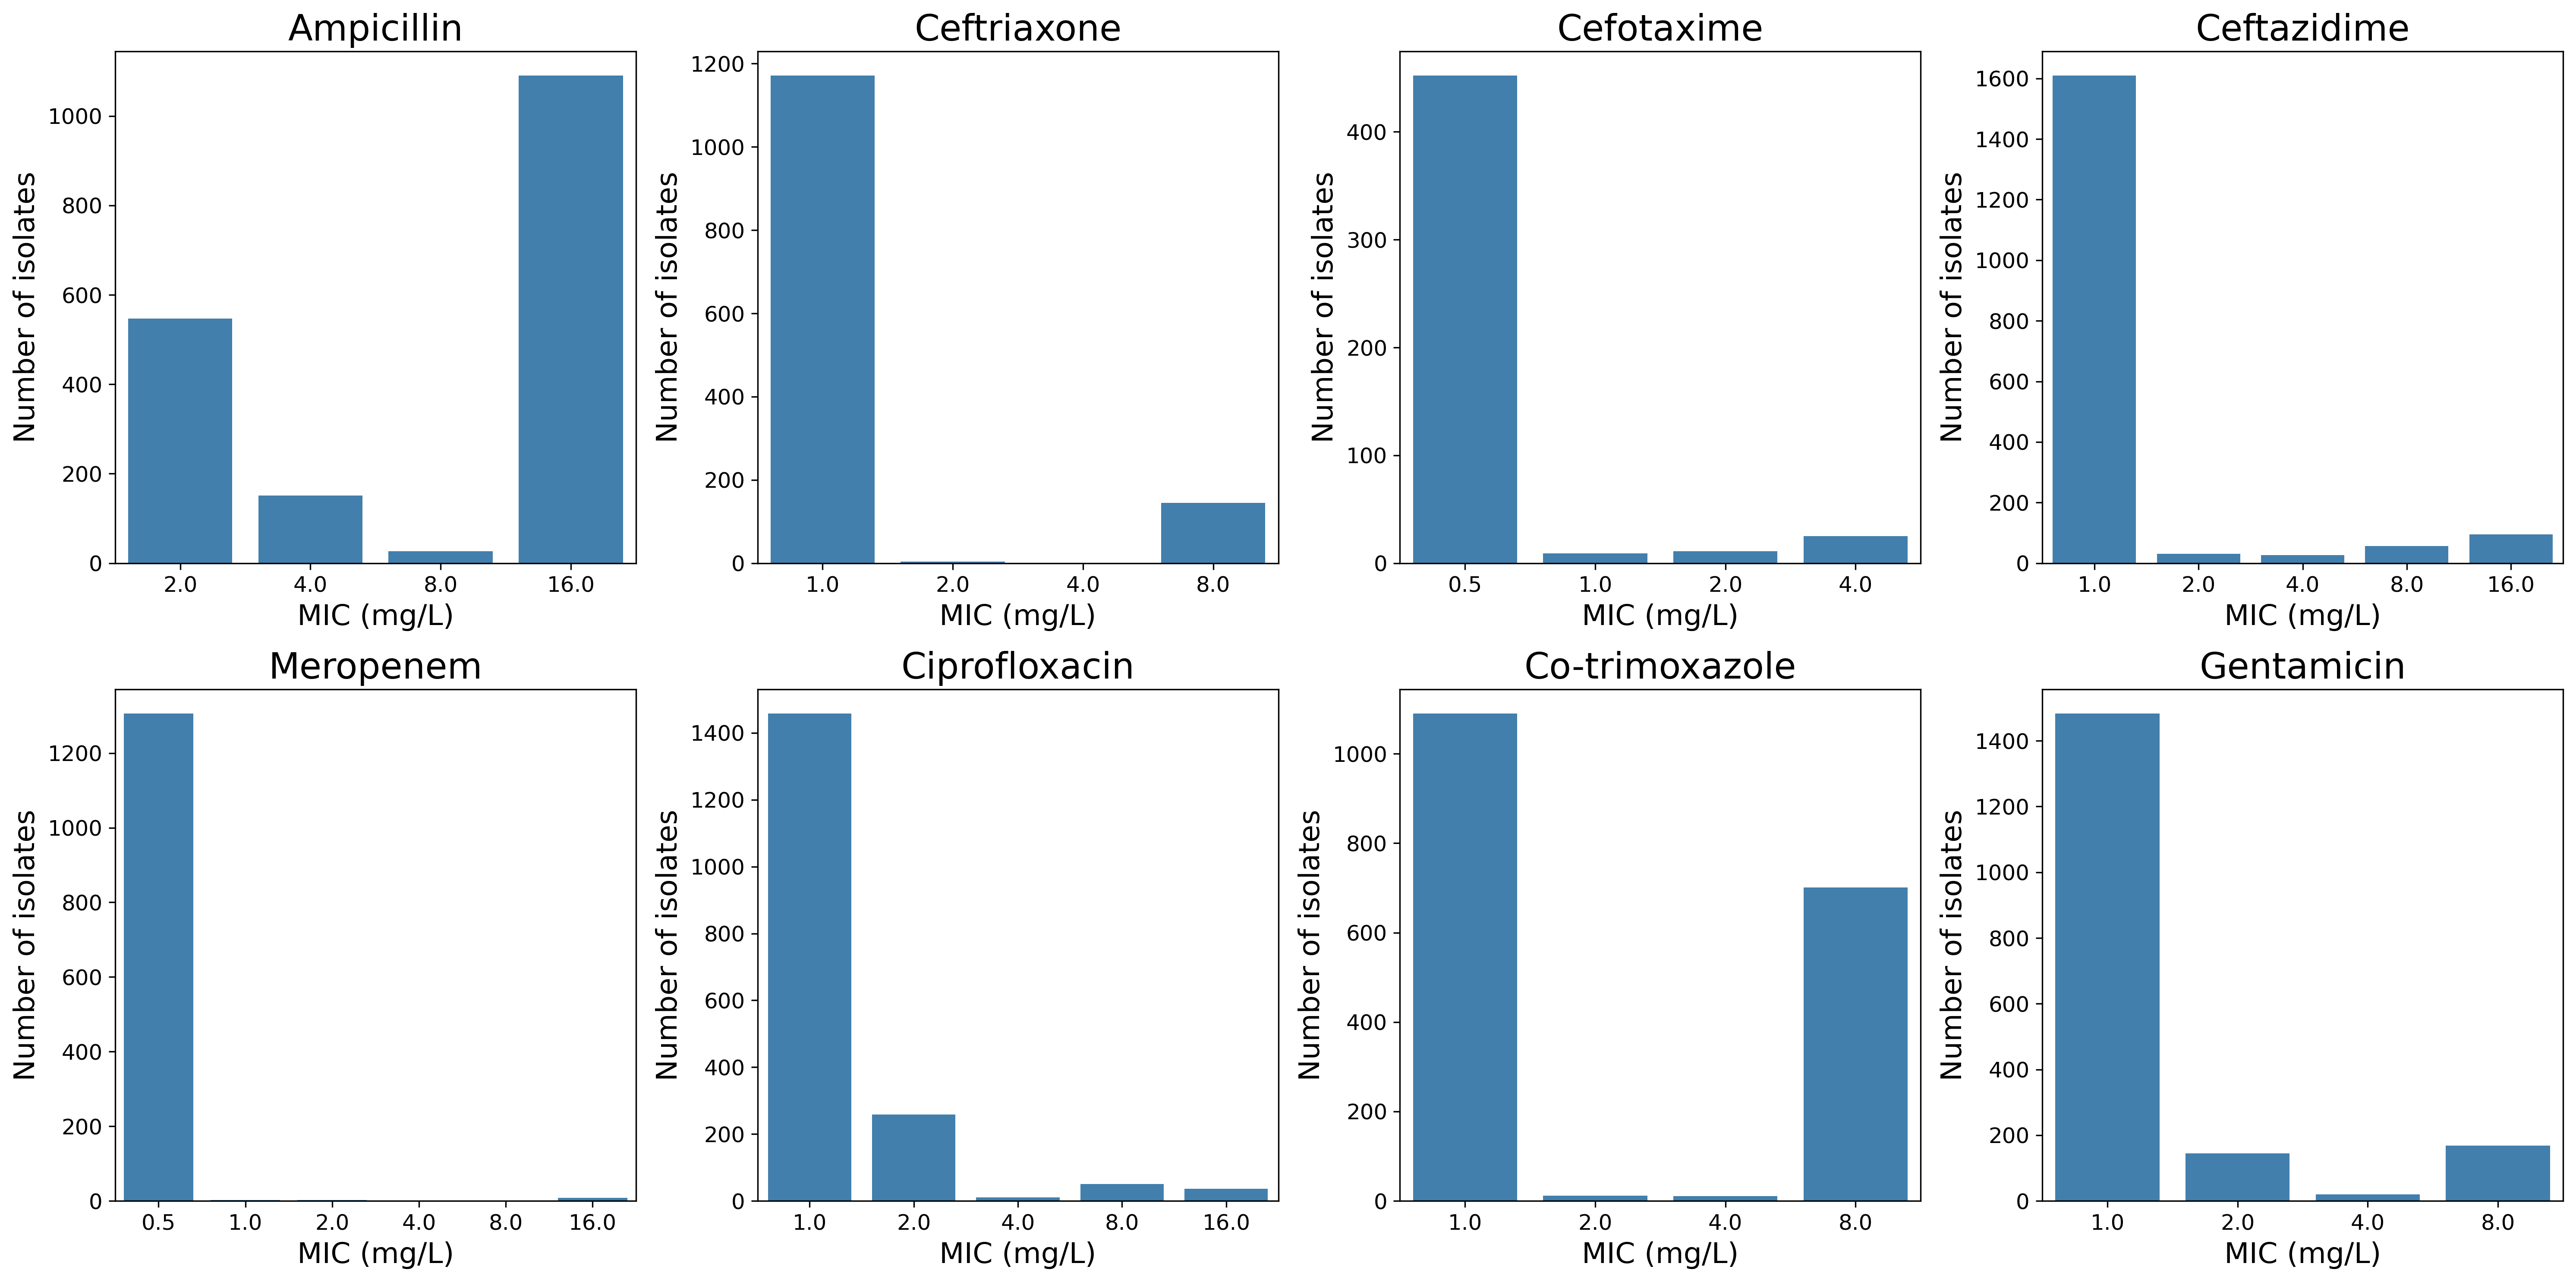

In [3]:
# So this makes supplementary figure S6 
# Esentially the MICs or each of the antibiotics included in this research.
# It also reports a table interpretation


print(sorted(list(set(list(meta_data.antibiotic_name)))))
# Making the grid of subplots
fig = plt.figure(figsize=(20,10), dpi=300)
ax1 = plt.subplot2grid((2,4),(0,0), rowspan = 1 , colspan= 1)
ax2 = plt.subplot2grid((2,4),(0,1), rowspan = 1 , colspan= 1)
ax3 = plt.subplot2grid((2,4),(0,2), rowspan = 1 , colspan= 1)
ax4 = plt.subplot2grid((2,4),(0,3), rowspan = 1 , colspan= 1)
ax5 = plt.subplot2grid((2,4),(1,0), rowspan = 1 , colspan= 1)
ax6 = plt.subplot2grid((2,4),(1,1), rowspan = 1 , colspan= 1)
ax7 = plt.subplot2grid((2,4),(1,2), rowspan = 1 , colspan= 1)
ax8 = plt.subplot2grid((2,4),(1,3), rowspan = 1 , colspan= 1)

# Getting each atnibiotics dataset
amp_res = meta_data.loc[meta_data.antibiotic_name == "ampicillin"]
cef_res = meta_data.loc[meta_data.antibiotic_name == "ceftriaxone"]
ctx_res = meta_data.loc[meta_data.antibiotic_name == "cefotaxime"]
cfz_res = meta_data.loc[meta_data.antibiotic_name == "ceftazidime"]
mem_res = meta_data.loc[meta_data.antibiotic_name == "meropenem"]
cip_res = meta_data.loc[meta_data.antibiotic_name == "ciprifloxacin"]
cot_res =  meta_data.loc[meta_data.antibiotic_name == "trimethoprim-sulfamethoxazole"]
gen_res =  meta_data.loc[meta_data.antibiotic_name == "gentamicin"]

# Sensoring the cefotaxime (alternate method of interpretation)
ctx_cen = list(ctx_res.inferred_mic)

ctx_cen_2 = []
for i in ctx_cen:
    if i < 0.5:
        ctx_cen_2.append(0.5)
    elif i> 4:
        ctx_cen_2.append(4)
    else:
        ctx_cen_2.append(i)
ctx_cen = pd.Series(ctx_cen_2)

# Getting the value counts for each one (R/S Values)
print("ampicillin")
print(amp_res.eucast_interpretation.value_counts())
print("ceftriaxone")
print(cef_res.eucast_interpretation.value_counts())
print("cefotaxime")
print(ctx_res.eucast_interpretation.value_counts())
print("ceftazidime")
print(cfz_res.eucast_interpretation.value_counts())
print("meropenem")
print(mem_res.eucast_interpretation.value_counts())
print("ciprofloxacin")
print(cip_res.eucast_interpretation.value_counts())
print("co-trimoxazole")
print(cot_res.eucast_interpretation.value_counts())
print("gentamicin")
print(gen_res.eucast_interpretation.value_counts())

# Then making the plot
sns.countplot(amp_res.inferred_mic, color="#3182bd", ax=ax1)
sns.countplot(cef_res.inferred_mic, color="#3182bd", ax=ax2)
sns.countplot(ctx_cen, color="#3182bd", ax=ax3)
sns.countplot(cfz_res.inferred_mic, color="#3182bd", ax=ax4)
sns.countplot(mem_res.inferred_mic, color="#3182bd", ax=ax5)
sns.countplot(cip_res.inferred_mic, color="#3182bd", ax=ax6)
sns.countplot(cot_res.inferred_mic, color="#3182bd", ax=ax7)
sns.countplot(gen_res.inferred_mic, color="#3182bd", ax=ax8)

axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i in axs:
    i.set_xlabel("MIC (mg/L)", fontsize=16)
    i.set_ylabel("Number of isolates", fontsize=16)
    i.tick_params(axis='x', labelsize=12)
    i.tick_params(axis='y', labelsize=12)

ax1.set_title("Ampicillin", fontsize =20)
ax2.set_title("Ceftriaxone", fontsize =20)
ax3.set_title("Cefotaxime", fontsize =20)
ax4.set_title("Ceftazidime", fontsize =20)
ax5.set_title("Meropenem", fontsize =20)
ax6.set_title("Ciprofloxacin", fontsize =20)
ax7.set_title("Co-trimoxazole", fontsize =20)
ax8.set_title("Gentamicin", fontsize =20)

plt.tight_layout()



In [4]:



# This generates a dictionary containing each of the antibiotics and the isolates they were tested for
abx = {k: sorted(list(meta_data.loc[meta_data.antibiotic_name == k].guuid)) for k in list(set(meta_data.antibiotic_name))}

print("")
print("Antibiotics ")
for k in abx:
    print(k, ":" ,len(abx[k]), "isolates")

# MIC data was interpreted according to EUCAST non-susceptibile (i.e. I or R as R, S as S) clinical breakpoints

abx_results = {}
for g in guuids: 
    abx_results[g] = {k:"" for k in abx}
    g_data = meta_data.loc[meta_data.guuid == g]
    for k in abx_results[g]:
        if k not in list(g_data.antibiotic_name):
            pass
        else:
            abx_results[g][k] = list(g_data.loc[g_data.antibiotic_name == k].eucast_interpretation)[0]

print("")
print("")
# Now we will summarize this data, note this (for the antibiotics studied in this paper) is available as a supplementary table!
for k in abx:
    k_list = []
    for j in abx_results:
        if abx_results[j][k] != "":
            k_list.append(abx_results[j][k])
    print(k, Counter(k_list))





Antibiotics 
trimethoprim-sulfamethoxazole : 1814 isolates
gentamicin : 1816 isolates
ceftazidime : 1818 isolates
meropenem : 1321 isolates
ciprifloxacin : 1815 isolates
ampicillin : 1815 isolates
cefotaxime : 497 isolates
ceftriaxone : 1321 isolates


trimethoprim-sulfamethoxazole Counter({'S': 1102, 'R': 701, 'I': 11})
gentamicin Counter({'S': 1628, 'R': 168, 'I': 20})
ceftazidime Counter({'S': 1609, 'R': 151, 'I': 58})
meropenem Counter({'S': 1311, 'R': 8, 'I': 2})
ciprifloxacin Counter({'S': 1366, 'R': 374, 'I': 75})
ampicillin Counter({'R': 1090, 'S': 725})
cefotaxime Counter({'S': 461, 'R': 25, 'I': 11})
ceftriaxone Counter({'S': 1171, 'R': 146, 'I': 4})


In [5]:

# =============================================================================
# Code block 2 - finding the output files
# =============================================================================

# Note this remains in dictionary output due to legacy code where we tried other databases and kept the option available
# However for code submitted with the paper, this was removed as legacy databases were not involved in the paper/ the code was not fully functional with them.

dbresult_link = {"resfinder_20191001_full":{"results":"result_tarballs/resfinderfull_20191001/",
                                          "db": "../db_preparation/resfinder_20191001/",
                                           "naming":"resfinderfull_20191001_names.csv"}}

# Note to use (this is demonstration code as opposed to full workings), please unpack the resfinderfull_20191001.tar.gz tarball before running below

# Loading in the output files

# Likewise, when we load results, we again kept a db so we could switch between different sets of results easily

output_files = {}


for k in dbresult_link:
    # Result dictionary , we initialise a dictionary and a "base key" 
    output_files[k] = {}
    base_key = dbresult_link[k]['results'] + dbresult_link[k]['results'].split("/")[-2] + "_"
    # Basically this is a way to create file paths for each output , 
    # it is easier to see if you unpack the tarball and explore
    # loading in ABRicate first
    output_files[k]["abricate"] = base_key + "abricate/"
    # Files are then found using list comprehensions
    abricate_files = [os.path.join(root, f) for root, dirs, files 
                  in os.walk(output_files[k]["abricate"])
                 for f in files if f != "summary.tab"]
    abricate_files = {k.split("/")[-1].split("_")[0]:k for k in abricate_files}
    output_files[k]["abricate"] = abricate_files
    # Loading the KmerRes files
    output_files[k]["kmerres"] = base_key + "kmerres/"
    kmerres_files = [os.path.join(root, f) for root, dirs, files in os.walk(output_files[k]["kmerres"])
                     for f in files if ".KmerRes" in f]
    kmerres_files = {k.split("/")[-1].split("_")[0]:k for k in kmerres_files}    
    output_files[k]["kmerres"] = kmerres_files
    # The SRST2 files
    output_files[k]['srst2'] = base_key + "srst2/"
    srst2_files = [os.path.join(root, f) for root, dirs, files in os.walk(output_files[k]['srst2']) for f in files]
    srst2_files = {k.split("/")[-1].split("_")[0]:k for k in srst2_files}
    output_files[k]['srst2'] = srst2_files
    # Finally we'll put the whole ariba summary into a pandas database
    output_files[k]["ariba"] = base_key + "ariba.csv"
    ariba_names = [k.split("/")[1].split("_")[0] for k in list(pd.read_csv(output_files[k]["ariba"]).name)]
    ariba_summary = pd.read_csv(output_files[k]["ariba"]).fillna("")
    ariba_summary.index = ariba_names
    output_files[k]["ariba"] = ariba_summary
    


# Note because of the different way in which ARIBA is loaded in we also add a special reading function
def ariba_parser(s):
    s_clusters = sorted(list(set([k.split(".")[0] for k in s.index if "cluster" in k and ".match" in k])))
    s_clusters = [k for k in s_clusters if s[k+".match"] == "yes"]
    s_genes = [s[k+ ".ref_seq"] for k in s_clusters]
    return s_genes





In [6]:

# =============================================================================
# Code block 3 - loading the database
# =============================================================================

# Again some hangovers from when I used multiple different databases

poss_dbs = ["resfinder_20191001_full"]

# As part of this code, we load the database, create new names with simple formatting (as each program deals with the headers in a different way)
# Linkdictionaries (rlinks and links) both link between original headers and newids. One one way, and the other the otherway
# We then calculated similarity of elements in the database

sim_matrices = {}
jac_sim_matrices = {}
links = {}
rlinks = {}

# Again left in functionality for multiple databases but in uploaded code only using one

for db_choice in poss_dbs:
    print(db_choice)
    # Database
    db = dbresult_link[db_choice]["db"]
    formatted_db = db +"db_formatted.fasta"
    linkfile = db + "db_link.csv"
    clstrfile = db + "db_clustered.clstr"

    #results

    abricate_files = output_files[db_choice]['abricate']
    kmerres_files = output_files[db_choice]['kmerres']
    srst2_files = output_files[db_choice]['srst2']
    ariba_summary = output_files[db_choice]['ariba']


    # 1. loading the link file
    link = pd.read_csv(linkfile, index_col=0, header=None)
    rlink = pd.read_csv(linkfile, index_col=1, header=None)
    # 2. loading the database
    res_db = SeqIO.to_dict(SeqIO.parse(formatted_db, "fasta"))

    # 3. Next were going to do all vs all similarity of the resfinder database

    # The primary way we are going to do this in the manuscript is using kmer sharing
    # The reasoning we do this this way, is there is no cut off to easily define clusters into families
    # Further the way a lot of programs will get confused when comparing similar genes, is if they have subsections of similar sequence, not necessarily overall identity
    # We wanted to do this as flexibly as possible
    # Its primary use is to give us units of "genes" which we can work on.

    
      # Any isolates which share a 17mer

    jac_sim_matrix = pd.DataFrame(np.zeros((len(res_db.keys()),len(res_db.keys()) )), 
                             columns = sorted(list(res_db.keys())), index=sorted(list(res_db.keys())))
    # For this similarity we will use 17-mers (one of the prefixes using MASH, note several others were checked prior to this for their effects)
    # Clusters marked by this are fairly similar to other k-mer sizes
    res_db_kmers = {k: set([str(res_db[k].seq)[i:i+17] for i in range(len(res_db[k].seq)-16)]) for k in res_db.keys()}

    def calculate_jac_sim(l1, l2):
        intersection = len(res_db_kmers[l1].intersection(res_db_kmers[l2]))
        union = len(res_db_kmers[l1].union(res_db_kmers[l2]))
        return(intersection/union)

    # This code actually goes through populating this matrix, 
    # However takes 30 minutes to run, and for the sake of running this code quickly on line, I will
    # use a matrix I made earlier (using thie code)
    if os.path.isfile("readymade"+ "_{0}_sim_matrix.csv" .format(db_choice)) == False:
        for n in tnrange(len(res_db_kmers)):
            k  = list(res_db_kmers.keys())[n]
            for j in res_db_kmers:
                jac_sim_matrix.loc[k][j] = calculate_jac_sim(k, j)
        jac_sim_matrix.to_csv("readymade"+ "_{0}_sim_matrix.csv" .format(db_choice))

    jac_sim_matrix = pd.read_csv("readymade"+ "_{0}_sim_matrix.csv" .format(db_choice), index_col = 0)

    
    # In addition to sense check these clusters I have also created a sim_matrix based on CD-HIT clustering
    
    sim_matrix = pd.DataFrame(np.zeros((len(res_db.keys()),len(res_db.keys()) )), 
                             columns = sorted(list(res_db.keys())), index=sorted(list(res_db.keys())))

    #So reading the cluster file
    # this simply parses this + formatting.

    clusters ={}
    with open(clstrfile, "r") as f:
        for line in f:
            if line[0] == ">":
                cluster_no = int(line.rstrip("\n").split(" ")[-1])
                clusters[int(line.rstrip("\n").split(" ")[-1])] = []
            else:
                clusters[cluster_no].append(line.rstrip("\n").split(">")[-1].split("...")[0])
    for k in clusters:
        for i in clusters[k]:
            for j in clusters[k]:
                sim_matrix.loc[i][j] = 1

    # Note my reasoning for clustering this way in addition to Kmer clusering is to examine the clusters to check the mostly make sense
    

    
    # Storing everything in objects to have access to them later
    sim_matrices[db_choice] = sim_matrix
    jac_sim_matrices[db_choice] = jac_sim_matrix
    links[db_choice] = link
    rlinks[db_choice] = rlink
    rlinks[db_choice] = rlink

resfinder_20191001_full


## <span style="color: blue;"> Setting up the analysis class </span>


In the next section of code, the aim is to define a class which performs most of the comparisons for us. 

#### Defining useful functions - Code block 4
Before we set up the class we define useful functions
There are some general useful functions and also some more specific ones. 
The specific and less obvious ones are below.

**CLUSTERING**

recursive cluster => This essentially uses netrowkx to greate a graph, which links togehter elements with non-zero similarity. 
The other two functions make_tuples and name list are simplications of bits within the recursive cluster functions

**AGREEMENT**

We also use a function to define agreement
This is then useful for quick and easy ready of 
which programs have agreed together. 
Note the panel is the same one as included in a supplementary image.

![image](method_combinations.png)



#### Reading in the data - Code block 5
Once we have the tools to analyse the data we actually read in the data

This does the following steps
For each of ABRicate, ARIBA, KmerResistance, SRST2 we
1. read in its file
2. Pull out the TRGs it identifies and relabel them with their original names
3. Separate these into groups according to their relavent antibiotics.




This is done using an external spreadsheet (which suggests putative families for all patterns of genes seen)

In [7]:

# =============================================================================
# Code block 4 - useful functions
# =============================================================================



###### CLUSTERING FUNCTIONS  ######


def make_tuples(l):
    # Make all possible tuples in a list
    output = []
    for i in range(len(l)):
        for j in range(len(l)):
            output.append((l[i],l[j]))
    output = sorted(list(set(output)))
    return output

def name_list(l, d):
    #rename all elements of a list
    return [d[k] for k in l]


def recursive_cluster(df, l):
    # This function partitions a matrix into all groups with any linking pair, i.e, if A and B are similar, and B and C are similar, A, B, C are in a group together
    # You need to do this recursively, as, as you add more elements, you group get potentially broader
    groups = {}
    # First we get all linked pairs. into a list l
    for i in l:
        i_data = df.loc[i]
        i_group = [i]
        for j in l:
            if j != i: 
                if i_data[j] != 0:
                    i_group.append(j)
        i_group = sorted(i_group)
        groups[i] =  i_group
    # Assign numbers to the elements of l and then generate a dictionary to link numbers and names
    naming = {}
    reverse_naming  = {}
    m = 1
    for i in l:
        naming[i] = m
        reverse_naming[m] = i
        m += 1
    # Grouping tuples like a graph using networkx, (this is a graphing tool , which then compares things which are linked)
    final_tuples = []
    for i in groups:
        final_tuples = final_tuples + make_tuples([naming[j] for j in groups[i]])
    final_tuples = sorted(list(set(final_tuples)))
    graph=nx.Graph(final_tuples)
    output = [name_list(list(c), reverse_naming) for c in nx.connected_components(graph)]
    return output

###### AGREEMENT PATTERN FUNCTIONS 

# Note for these functions they always assume the results are put in the correct order
# i.e. ABRicate, ARIBA, KmerResistance, SRST2

# First we start with a general agreement function 
def agreement_pattern(l1, l2, l3, l4):
    args = deepcopy(locals())
    arg_list = ['l1', 'l2', 'l3', 'l4']
    for key in arg_list:
        args[key] = ":".join(sorted(args[key]))
    patterns = {}
    output = []
    starting_no = 0
    for key in arg_list:
        if args[key] not in patterns:
            starting_no += 1
            patterns[args[key]] = starting_no
            output.append(starting_no)
        else:
            output.append(patterns[args[key]])
    return output
    

# Now for gene agreement, I use this program to say which genes (from a list) each method has found
def pres_bin(l1, l2):
    output = []
    for k in l1:
        if k in l2:
            output.append("1")
        else:
            output.append("0")
    return output

# Here is the agreement function again, but this time i've dropped the sort function. 
# This enables me to use the output from pres_bin directly to make the patterns as defined above 
def pres_bin_agreement_pattern(l1, l2, l3, l4):
    args = deepcopy(locals())
    arg_list = ['l1', 'l2', 'l3', 'l4']
    for key in arg_list:
        args[key] = ":".join(args[key])
    patterns = {}
    output = []
    starting_no = 0
    for key in arg_list:
        if args[key] not in patterns:
            starting_no += 1
            patterns[args[key]] = starting_no
            output.append(starting_no)
        else:
            output.append(patterns[args[key]])
    return output



In [8]:

# =============================================================================
# Code block 5 - The "isolate" class
# =============================================================================

# This is the workhorse for most of the processing
# For each isolate it reads the output files, reputs things into original names, 
# It then groups things as 'genes'
# It then looks at that gene is (e.g. how it is classified in different databases, what CARD thinks are its relavent phenotypes. 
# what name it will have in subsequent pictures)


class isolate:
    
    def __init__(self,guuid, db_choice):
        self.guuid = guuid

        abricate_fl = output_files[db_choice]['abricate'][self.guuid]
        kmerres_fl = output_files[db_choice]['kmerres'][self.guuid]
        ariba_summary = output_files[db_choice]['ariba']
        link = links[db_choice]
        rlink = rlinks[db_choice]
        sim_matrix = sim_matrices[db_choice]
        naming_fl = pd.read_csv(dbresult_link[db_choice]['naming'])

        
        # ABRicate
        # Each section of this code does similar things, 1. read the file , 2 translate the genes, 
        self.abricate_fl = pd.read_csv(abricate_fl, delimiter= "\t").fillna("")

        
        ################## ADDITION FOR INTEREST #####################################
        # NOTE I HAVE LEFT THE BELOW FILTERING CODE IN JUST IN CASE THOSE TESING THIS SCRIPT WANT TO TRY VARING CUTOFFS
        # SIMILAR BITS CAN BE ADDED TO ALL THE OTHER FILES, NOTE THE 60, 90 CUTOFFS ARE THOSE USED BY RESFINDER AS DEFAULT!
#         self.abricate_fl = self.abricate_fl.loc[self.abricate_fl['%COVERAGE'] > 60.0]
#         self.abricate_fl = self.abricate_fl.loc[self.abricate_fl['%IDENTITY'] > 90.0]

        self.abricate_genes = sorted(list(set([link.loc[k][1] for k in list(self.abricate_fl['GENE'])])))

        
        # ARIBA
        self.ariba_data = ariba_parser(ariba_summary.loc[self.guuid])
        self.ariba_genes = sorted(list(set([link.loc[k][1] for k in self.ariba_data])))

        # KmerResistance
        # We apply the 70% cutoff manually as it doesn't appear to do this reliabbly
        # So we will re-apply this.)
        self.kmerres_ofl = pd.read_csv(kmerres_fl, delimiter = "\t").fillna("")
        self.kmerres_fl = self.kmerres_ofl.loc[self.kmerres_ofl.template_id > 70.0]
        self.kmerres_genes = sorted(list(set([link.loc[k][1] for k in [j for j in list(self.kmerres_fl['#Template']) if "resfindernewid" in j]])))

        # SRST2
        # Note for SRST2 we have another bit which doesn't quite work
        # It does not make a file if it finds no genes
        # Therefore we put it into a try except group

        try:
            self.srst2_fl = pd.read_csv(output_files[db_choice]['srst2'][self.guuid], delimiter = "\t").fillna("")
            self.srst2_genes = sorted(list(set([link.loc[k][1] for k in list(self.srst2_fl['allele'])])))
        except:
            self.srst2_fl = "N/A"
            self.srst2_genes = []

        
        ### Aggregating genes. 
        
        self.geno_full = {"abricate":self.abricate_genes, "ariba":self.ariba_genes, 
                         "kmerres": self.kmerres_genes, "srst2":self.srst2_genes}
        self.all_genes = sorted(list(set(self.abricate_genes + self.ariba_genes + self.srst2_genes + self.kmerres_genes)))
        
        
        ### Defining gene families 

        gene_df = pd.DataFrame(np.zeros((len(self.all_genes),len(self.all_genes) )), 
                               columns =self.all_genes, index=self.all_genes)
        for l in gene_df.index:
            for j in gene_df.columns:
                gene_df.loc[l][j] = sim_matrix.loc[rlink.loc[l][0]][rlink.loc[j][0]]
        self.gene_families = recursive_cluster(gene_df, gene_df.index)
        
#         ### Assessing levels of agreement
#         # Here we define three things, Firstly, do results agree for all genes for a particular antibiotic class
#         # Then do they agree for a whole isolate
#         # Then finally we do a bit more delving into the patterns of disagreement
#         # Whole isolate level agreement
        self.isolate_patterns = agreement_pattern(sorted(self.abricate_genes), sorted(self.ariba_genes),
                                                sorted(self.kmerres_genes), sorted(self.srst2_genes))
        self.isolate_agreement = (self.isolate_patterns == [1,1,1,1])
        

        # This is going to be a dictionary which pulls together all of the info about each gene hit
        self.gene_info = {}
        # This is going to be a dictionary for phenotypic prediction (allele presence and absence.)
        self.allele_info = {}
        
#         ###For each gene
        self.genes_identified = {}
        self.gene_patterns = {}
        for pat in self.gene_families:
            pat_id = ":".join(pat)
            pat_string = [pres_bin(pat, self.abricate_genes),
                          pres_bin(pat, self.ariba_genes), 
                          pres_bin(pat, self.kmerres_genes), 
                          pres_bin(pat, self.srst2_genes)]
            self.gene_patterns[pat_id] = pres_bin_agreement_pattern(pat_string[0], pat_string[1], pat_string[2], pat_string[3])
            pat_string = "|".join([":".join(i) for i in pat_string])
            self.genes_identified[pat_id] = pat_string
            
        # Next for some of the pictures its helpful to define some of the sensible naming stuff for each gene
        # It is useful to do this in the class description
        
        for g in self.genes_identified:
            self.gene_info[g] = {
                "pattern":self.gene_patterns[g],
                "presence_absence":self.genes_identified[g],
                "gene_family":"",
                "kmer_family":"",
                "card_family":"",
                "picture_family":"",
                "relative_phenotype":"",
                "pairwise": pd.DataFrame(np.zeros((4,4)), index=["ABRicate", "ARIBA", "KmerRes", "SRST2"], 
                                         columns=["ABRicate", "ARIBA", "KmerRes", "SRST2"])
            }
            # Note I have established that each gene identified only belongs to one "gene family" in the naming csv 
            # Further that has the corollary that each gene_identified can be linked to its "family"
            # by any single element
            # So chosing an element
            h = g.split(":")[0]
            h_found = 0 # Note this is a sense checking variable, we want to make sure that we have this info for any gene we find
            # This then links each allele with its "family"
            for i in range(len(naming_fl)):
                if h in naming_fl.iloc[i].gene_family:
                    g_cardname = naming_fl.iloc[i].family_card
                    g_genefamily = naming_fl.iloc[i].gene_family
                    g_kmerfamily = naming_fl.iloc[i].kmer_family
                    g_relphen = naming_fl.iloc[i].rel_phenotype
                    g_picfamily = naming_fl.iloc[i].picture_family
                    self.gene_info[g]["card_family"] = g_cardname
                    self.gene_info[g]["gene_family"] = g_genefamily
                    self.gene_info[g]["kmer_family"] = g_kmerfamily
                    self.gene_info[g]["picture_family"] = g_picfamily
                    self.gene_info[g]["relative_phenotype"] = g_relphen
                    h_found = 1
                    break
                else:
                    pass
            if h_found ==0 : # i.e. if the gene isn't included in the database
                print(h_found)
            # This code looks complex but is simply making a pairwise comparison for each gene (labelled by its pat string
            # I.e. for a gene proper rather than just an allele, and it compares how each program reports it)
            for p1 in ["ABRicate", "ARIBA", "KmerRes", "SRST2"]:
                if p1 == "ABRicate":
                    p1_string = self.genes_identified[g].split("|")[0]
                elif p1 == "ARIBA":
                    p1_string = self.genes_identified[g].split("|")[1]
                elif p1 == "KmerRes":
                    p1_string = self.genes_identified[g].split("|")[2]
                elif p1 == "SRST2":
                    p1_string = self.genes_identified[g].split("|")[3]
                for p2 in ["ABRicate", "ARIBA", "KmerRes", "SRST2"]:
                    if p2 == "ABRicate":
                        p2_string = self.genes_identified[g].split("|")[0]
                    elif p2 == "ARIBA":
                        p2_string = self.genes_identified[g].split("|")[1]
                    elif p2 == "KmerRes":
                        p2_string = self.genes_identified[g].split("|")[2]
                    elif p2 == "SRST2":
                        p2_string = self.genes_identified[g].split("|")[3]
                    if p1_string == p2_string:
                        self.gene_info[g]["pairwise"].loc[p1][p2] = 1
                    else:
                        pass

    

In [9]:
# Getting everything into that class

db_choice = "resfinder_20191001_full"


isolates = {}

# Now with the classes set up we read in everything into an isolates dict
# This is the key working code, essentially for every sample, it populates everything in the isolate class above


for n in tnrange(len(guuids)):
    k = guuids[n]
    x = isolate(k,db_choice)
    isolates[k] = x
    
sim_matrix = sim_matrices[db_choice]
jac_sim_matrix = jac_sim_matrices[db_choice]
rlink = rlinks[db_choice]
link = links[db_choice]

In [10]:
# Now just exploring some of that is in that isolate class
m = 1
# This M just basically sets a cut off at examining 1 isolate
# If you want to look at more just increase m



count = 0
for k in isolates:
    count +=1
    print(k)
    # First we see that all the alleles 
    print("*******ALLELE LISTS***********")
    print("ABRicate alleles", isolates[k].abricate_genes)
    print("ARIBA alleles", isolates[k].ariba_genes)
    print("KmerResistance alleles", isolates[k].kmerres_genes)
    print("SRST2 alleles", isolates[k].srst2_genes)
    print("")
    print("")
    
    
    print("*******GENE FAMILIES***********")
    # First the families found
    for l in isolates[k].gene_families:
        print(l)
    print("")
    print("")
    
    
    # Then a dictionary linking the allele strings together with the families
    # For each allele, it is assigned to a "gene" by kmer families, and these are then linked to form a pattern string
    # These strings are the the dictionary keys, and the acutal patterns in which they are found by each program is a value
    # The values look like this 1:0|1:1|1:1|1:1 , in this example, abricate found only 1 allele, whereas all other programs found 2 .
    # Strings go ABRicate|ARIBA|KmerRes|SRST2
    print("********WHAT EACH PROGRAM FOUND linked with gene families********")
    print(isolates[k].genes_identified)
    print("")
    print("")
    
    # Now we can talk about the genes each program found , we can go into better ways of describing them
    # This is done in the gene info dictionary
    # so picking one of the genes to make this clearer., I will pick the one with the most 
    g_list = [g.split(":") for g in isolates[k].genes_identified]
    pick = ":".join(max(g_list, key=len))
    print("********INFO ABOUT EACH GENE***********")
    print("picked gene", pick)
    print("")
    for key in isolates[k].gene_info[pick]:
        print(key)
        print(isolates[k].gene_info[pick][key])
        print("")
    
    # The only bit of this which needs a bit of additional explaining is the pairwise matrix
    # This looks at if any 2 programs agree, 1 if they agree, 0 if not (note by design the diagonal will always be 1)
    # Perfect agreement the whole matrix will be 1s, complete disagreement the matrix will be the identity matrix   
    if count >= m:
        break

00061137-91ba-470f-aa2f-181b487df07d
*******ALLELE LISTS***********
ABRicate alleles ["ant(3'')-Ia_1_X02340", "aph(3')-Ia_1_V00359", 'blaCMY-2_1_X91840', 'dfrA1_8_X00926', 'mdf(A)_1_Y08743', 'mef(B)_1_FJ196385', 'sul1_5_EU780013', 'sul3_2_AJ459418', 'tet(34)_1_AB061440', 'tet(B)_2_AF326777']
ARIBA alleles ['aadA1_3_JQ414041', "aph(3')-Ia_1_V00359", 'blaCMY-2_1_X91840', 'dfrA1_8_X00926', 'mdf(A)_1_Y08743', 'sul1_2_U12338', 'sul3_2_AJ459418', 'tet(B)_2_AF326777']
KmerResistance alleles ["ant(3'')-Ia_1_X02340", "aph(3')-Ia_1_V00359", 'blaCMY-2_1_X91840', 'dfrA1_5_EU089668', 'mdf(A)_1_Y08743', 'sul1_2_U12338', 'sul3_2_AJ459418', 'tet(B)_2_AF326777']
SRST2 alleles ['aadA11_2_AJ567827', 'aadA12_1_AY665771', 'aadA17_1_FJ460181', 'aadA1_3_JQ414041', 'aadA24_1_AM711129', "aph(3')-Ia_1_V00359", 'blaCMY-114_1_KM087846', 'blaCMY-2_1_X91840', 'dfrA1_10_AF203818', 'dfrA1_7_AJ400733', 'mdf(A)_1_Y08743', 'sul1_9_AY963803', 'sul3_2_AJ459418', 'tet(B)_2_AF326777']


*******GENE FAMILIES***********
['aad

In [11]:
# Number of alleles identified across the whole dataset:
alleles_list = []
total_genes = 0
abricate_totallele = 0
ariba_totallele = 0
kmerres_totallele = 0
srst2_totallele = 0

for k in isolates:
    for g in isolates[k].gene_info:
        total_genes += 1
        for m in g.split(":"):
            alleles_list.append(m)
            
print("total alleles found by all methods", len(alleles_list))
print("total genes", total_genes)




total alleles found by all methods 15588
total genes 10487


In [12]:
# This bit is just a bit extra for the beta-lactamases, in particular, stating which ESBLs and carbapenemases we have found
# This is predominantly for describing the data (see first paragraph of real data)
# Note I need too remember to take the BLM database.

database = "../db_preparation/resfinder_20191001_blm/beta-lactam.fsa"
blm_names = sorted([k.id for k in SeqIO.parse(database, "fasta")])

# So the lists below I have dug out manually from the data
# This is all beta-lactamases (as found by ABRicate, our "baseline" method)

found_list = []
print(len(isolates))
for i in isolates:
    for k in isolates[i].abricate_genes:
        if k in blm_names:
            found_list.append(k)
            
found_list = sorted(list(set(found_list)))
for k in found_list:
    print(k)

# This is ESBL only
esbls = ['blaCTX-M-139_1_KC107824', 'blaCTX-M-14_1_AF252622', 'blaCTX-M-14b_1_DQ359215', 'blaCTX-M-15_1_AY044436', 'blaCTX-M-189_1_FJ657512', 'blaCTX-M-1_1_DQ915955', 'blaCTX-M-27_1_AY156923', 'blaCTX-M-3_1_Y10278', 'blaCTX-M-55_1_DQ810789', 'blaCTX-M-9_1_AF174129', 'blaSHV-12_1_KF976405']
# This is carbapenemases only
carbapenemases = ['blaIMP-70_1_MG748725', 'blaKPC-2_1_AY034847', 'blaNDM-1_1_FN396876', 'blaNDM-5_1_JN104597', 'blaNDM-7_1_JX262694','blaOXA-48_1_AY236073' ]



1818
blaACT-15_1_JX440356
blaCARB-2_1_M69058
blaCMY-2_1_X91840
blaCMY-37_1_AB280919
blaCMY-42_1_HM146927
blaCMY-4_1_LNHZ01000079
blaCMY-51_1_JQ733571
blaCMY-6_1_AJ011293
blaCMY-70_1_JX440350
blaCTX-M-139_1_KC107824
blaCTX-M-14_1_AF252622
blaCTX-M-14b_1_DQ359215
blaCTX-M-15_1_AY044436
blaCTX-M-189_1_FJ657512
blaCTX-M-1_1_DQ915955
blaCTX-M-27_1_AY156923
blaCTX-M-3_1_Y10278
blaCTX-M-55_1_DQ810789
blaCTX-M-9_1_AF174129
blaDHA-1_1_Y16410
blaIMP-70_1_MG748725
blaKPC-2_1_AY034847
blaNDM-1_1_FN396876
blaNDM-5_1_JN104597
blaNDM-7_1_JX262694
blaOXA-181_1_CM004561
blaOXA-1_1_HQ170510
blaOXA-244_1_KP659189
blaOXA-2_1_DQ112222
blaOXA-48_1_AY236073
blaOXA-9_1_KQ089875
blaSHV-12_1_KF976405
blaSHV-48_1_AY263404
blaTEM-1A_1_HM749966
blaTEM-1B_1_AY458016
blaTEM-1C_1_FJ560503
blaTEM-1D_1_AF188200
blaTEM-208_1_KC865667
blaTEM-30_1_AJ437107
blaTEM-33_1_GU371926
blaTEM-35_1_KP860986
blaTEM-40_1_FR717535
blaTEM-84_1_AF427130


In [13]:
# Next to compare ESBLs between HICF (PHE) and other datasets (Oxford, APHA)


m = 0

phe_esbl = deepcopy(source['HICF'])
other_esbl = deepcopy(source["OXFORD"]+ source["APHA"])

for k in phe_esbl:
    esbl_pres = False
    for j in isolates[k].abricate_genes:
        if j in esbls:
            esbl_pres = True
    if esbl_pres == True:
        m +=1
print("PHE Isolates", m, len(phe_esbl))
            
m = 0
for k in other_esbl:
    esbl_pres = False
    for j in isolates[k].abricate_genes:
        if j in esbls:
            esbl_pres = True
    if esbl_pres == True:
        m += 1
        
print("Non PHE Isolates", m, len(other_esbl))

PHE Isolates 54 337
Non PHE Isolates 94 1481


In [14]:
# Doing the same for CPE

phe_cpe = deepcopy(source['HICF'])
other_cpe = deepcopy(source["OXFORD"]+ source["APHA"])
m = 0
for k in phe_cpe:
    cpe_pres = False
    for j in isolates[k].abricate_genes:
        if j in carbapenemases:
            cpe_pres = True
    if cpe_pres == True:
        m += 1
print("PHE Isolates", m, len(phe_cpe))

m = 0
for k in other_cpe:
    cpe_pres = False
    for j in isolates[k].abricate_genes:
        if j in carbapenemases:
            cpe_pres = True
    if cpe_pres == True:
        m += 1
print("Non PHE Isolates", m, len(other_cpe))

PHE Isolates 18 337
Non PHE Isolates 1 1481


## <span style="color: blue;">Producing figures</span>


From here on in, we move to specifically analysing the outputs found when using the October database (except for a few supplementary figures, cells which produce the data for these will be marked specifically with ##### SUPPLEMENTARY ALL DATABASES #####)

### Gene naming - code block 6

For each gene, and pattern of discorance, we want more interpretable gene (not allele) name. This is done using supplementary spreadsheets. 

### <span style="color: red;">NOTE FOR CLARITY , EXACTLY HOW GENES ARE NAMED IN PICTURES VS WHAT WAS ACTUALLY FOUND IS ALL ENCOMPASSED IN THE "gene_naming.csv" IN THIS DIRECTORY </span>

We then use these to begin constructing figures/figure components.



In [15]:
# =============================================================================
# Code block 6 - Giving the genes sensible names for pictures (2019 database)
# =============================================================================
db_choice = "resfinder_20191001_full"
# First we find which genes have been found across all methods
gene_list = []
for k in isolates:
    for g in isolates[k].all_genes:
        gene_list.append(g)
# Overall its approximately 200 different alleles, but there are fewer families 
# This next bit of code puts them into families to make sense for pictures, gene_families using CD hit clustering (for sense checking 
# Kmer ramilies for the actual working code 
gene_list = sorted(list(set(gene_list)))
print(len(gene_list))

gene_df = pd.DataFrame(np.zeros((len(gene_list),len(gene_list) )), 
                   columns =gene_list, index=gene_list)
for l in gene_df.index:
    for j in gene_df.columns:
        gene_df.loc[l][j] = sim_matrix.loc[rlink.loc[l][0]][rlink.loc[j][0]]
gene_families = recursive_cluster(gene_df, gene_df.index)


kmer_df = pd.DataFrame(np.zeros((len(gene_list),len(gene_list) )), 
                       columns =gene_list, index=gene_list)
for m in tnrange(len(kmer_df.index)):
    l = kmer_df.index[m]
    for j in kmer_df.columns:
        kmer_df.loc[l][j] = jac_sim_matrix.loc[rlink.loc[l][0]][rlink.loc[j][0]]
kmer_families = recursive_cluster(kmer_df, kmer_df.index)


# Next onto naming
# THis is done in a separate spreadsheet, gene_naming.csv which links together gene, family,which genes they share kmers with 
# and then what its actual family is (as listed in the CARD database front end) and finally what it ends up being called as in picutres
# Note for genes seen less than X times, they're grouped into "Other"

# Both for Figure 1, and generally to know how to group genes, we need to know how often they occur.
gene_nos = {g:0 for g in gene_list}
genemet_nos = {g:{"abricate":0, 
                  "ariba":0, 
                  "kmerres":0,
                  "srst2":0} for g in gene_list}

for g in gene_list:
    for i in isolates:
        if g in isolates[i].all_genes:
            gene_nos[g] += 1
        if g in isolates[i].abricate_genes:
            genemet_nos[g]["abricate"] += 1
        if g in isolates[i].ariba_genes:
            genemet_nos[g]["ariba"] += 1
        if g in isolates[i].kmerres_genes:
            genemet_nos[g]["kmerres"] += 1
        if g in isolates[i].srst2_genes:
            genemet_nos[g]["srst2"] += 1

# This however is a bit crude and can't really be used for counting genes, its just a useful set of dictionaries to have for latter times
# when looking at how common any given allele is. 

# so for pictures we need a measure of how commonly a picture gene is present.

pic_genes_df = pd.read_csv(dbresult_link[db_choice]["naming"])
pic_names = list(set(list(pic_genes_df.picture_family)))
pic_nos = {}
pic_nos_final = {}
for name in pic_names:
    pic_nos[name] = {"all":0, "abricate":0, "ariba":0, "kmerres":0, "srst2":0}
for k in isolates:
    for name in pic_names:
        name_sequences = list(pic_genes_df.loc[pic_genes_df.picture_family==name].sequence)
        seq_found = 0
        abricate_found = 0
        ariba_found =0
        kmerres_found =0
        srst2_found = 0
        for seq in name_sequences:
            if seq in isolates[k].all_genes:
                seq_found =1
            if seq in isolates[k].abricate_genes:
                abricate_found = 1
            if seq in isolates[k].ariba_genes:
                ariba_found = 1
            if seq in isolates[k].kmerres_genes:
                kmerres_found = 1
            if seq in isolates[k].srst2_genes:
                srst2_found = 1
        if seq_found == 1:
            pic_nos[name]["all"] += 1
        if abricate_found == 1:
            pic_nos[name]["abricate"] += 1
        if ariba_found == 1:
            pic_nos[name]["ariba"] += 1
        if kmerres_found == 1:
            pic_nos[name]["kmerres"] += 1
        if srst2_found == 1:
            pic_nos[name]["srst2"] += 1

for name in pic_nos:
    assert pic_nos[name]['all'] != 0


# So this then gives you for all genes, how many of each type there are ,  this is useful for fig 5
# Basically by simple names, it gives you counts by each method

print("*****GENES AND COUNTS BY METHOD ******")
print(pic_nos)
print("")
print("")
        
print("*****GENES AND COUNTS all, easier to read ******")
for k in sorted(pic_nos, key = lambda k : pic_nos[k]['all']):
    print(k, pic_nos[k]["all"])

251



*****GENES AND COUNTS BY METHOD ******
{'blaIMP': {'all': 2, 'abricate': 2, 'ariba': 2, 'kmerres': 2, 'srst2': 2}, 'blaOXA': {'all': 125, 'abricate': 124, 'ariba': 124, 'kmerres': 123, 'srst2': 123}, 'aar': {'all': 10, 'abricate': 10, 'ariba': 4, 'kmerres': 4, 'srst2': 4}, 'aph(4)': {'all': 25, 'abricate': 25, 'ariba': 25, 'kmerres': 25, 'srst2': 25}, 'blaCARB': {'all': 1, 'abricate': 1, 'ariba': 1, 'kmerres': 1, 'srst2': 1}, 'fos': {'all': 13, 'abricate': 12, 'ariba': 9, 'kmerres': 10, 'srst2': 10}, 'cat': {'all': 264, 'abricate': 264, 'ariba': 163, 'kmerres': 243, 'srst2': 161}, 'aac(3)': {'all': 178, 'abricate': 178, 'ariba': 162, 'kmerres': 162, 'srst2': 162}, 'mcr': {'all': 3, 'abricate': 3, 'ariba': 3, 'kmerres': 3, 'srst2': 3}, "ant(2'')": {'all': 9, 'abricate': 9, 'ariba': 9, 'kmerres': 9, 'srst2': 9}, '16S rRNA methyltransferase (G1405)': {'all': 4, 'abricate': 4, 'ariba': 4, 'kmerres': 4, 'srst2': 4}, 'macrolide esterase': {'all': 4, 'abricate': 4, 'ariba': 2, 'kmerres': 2, 

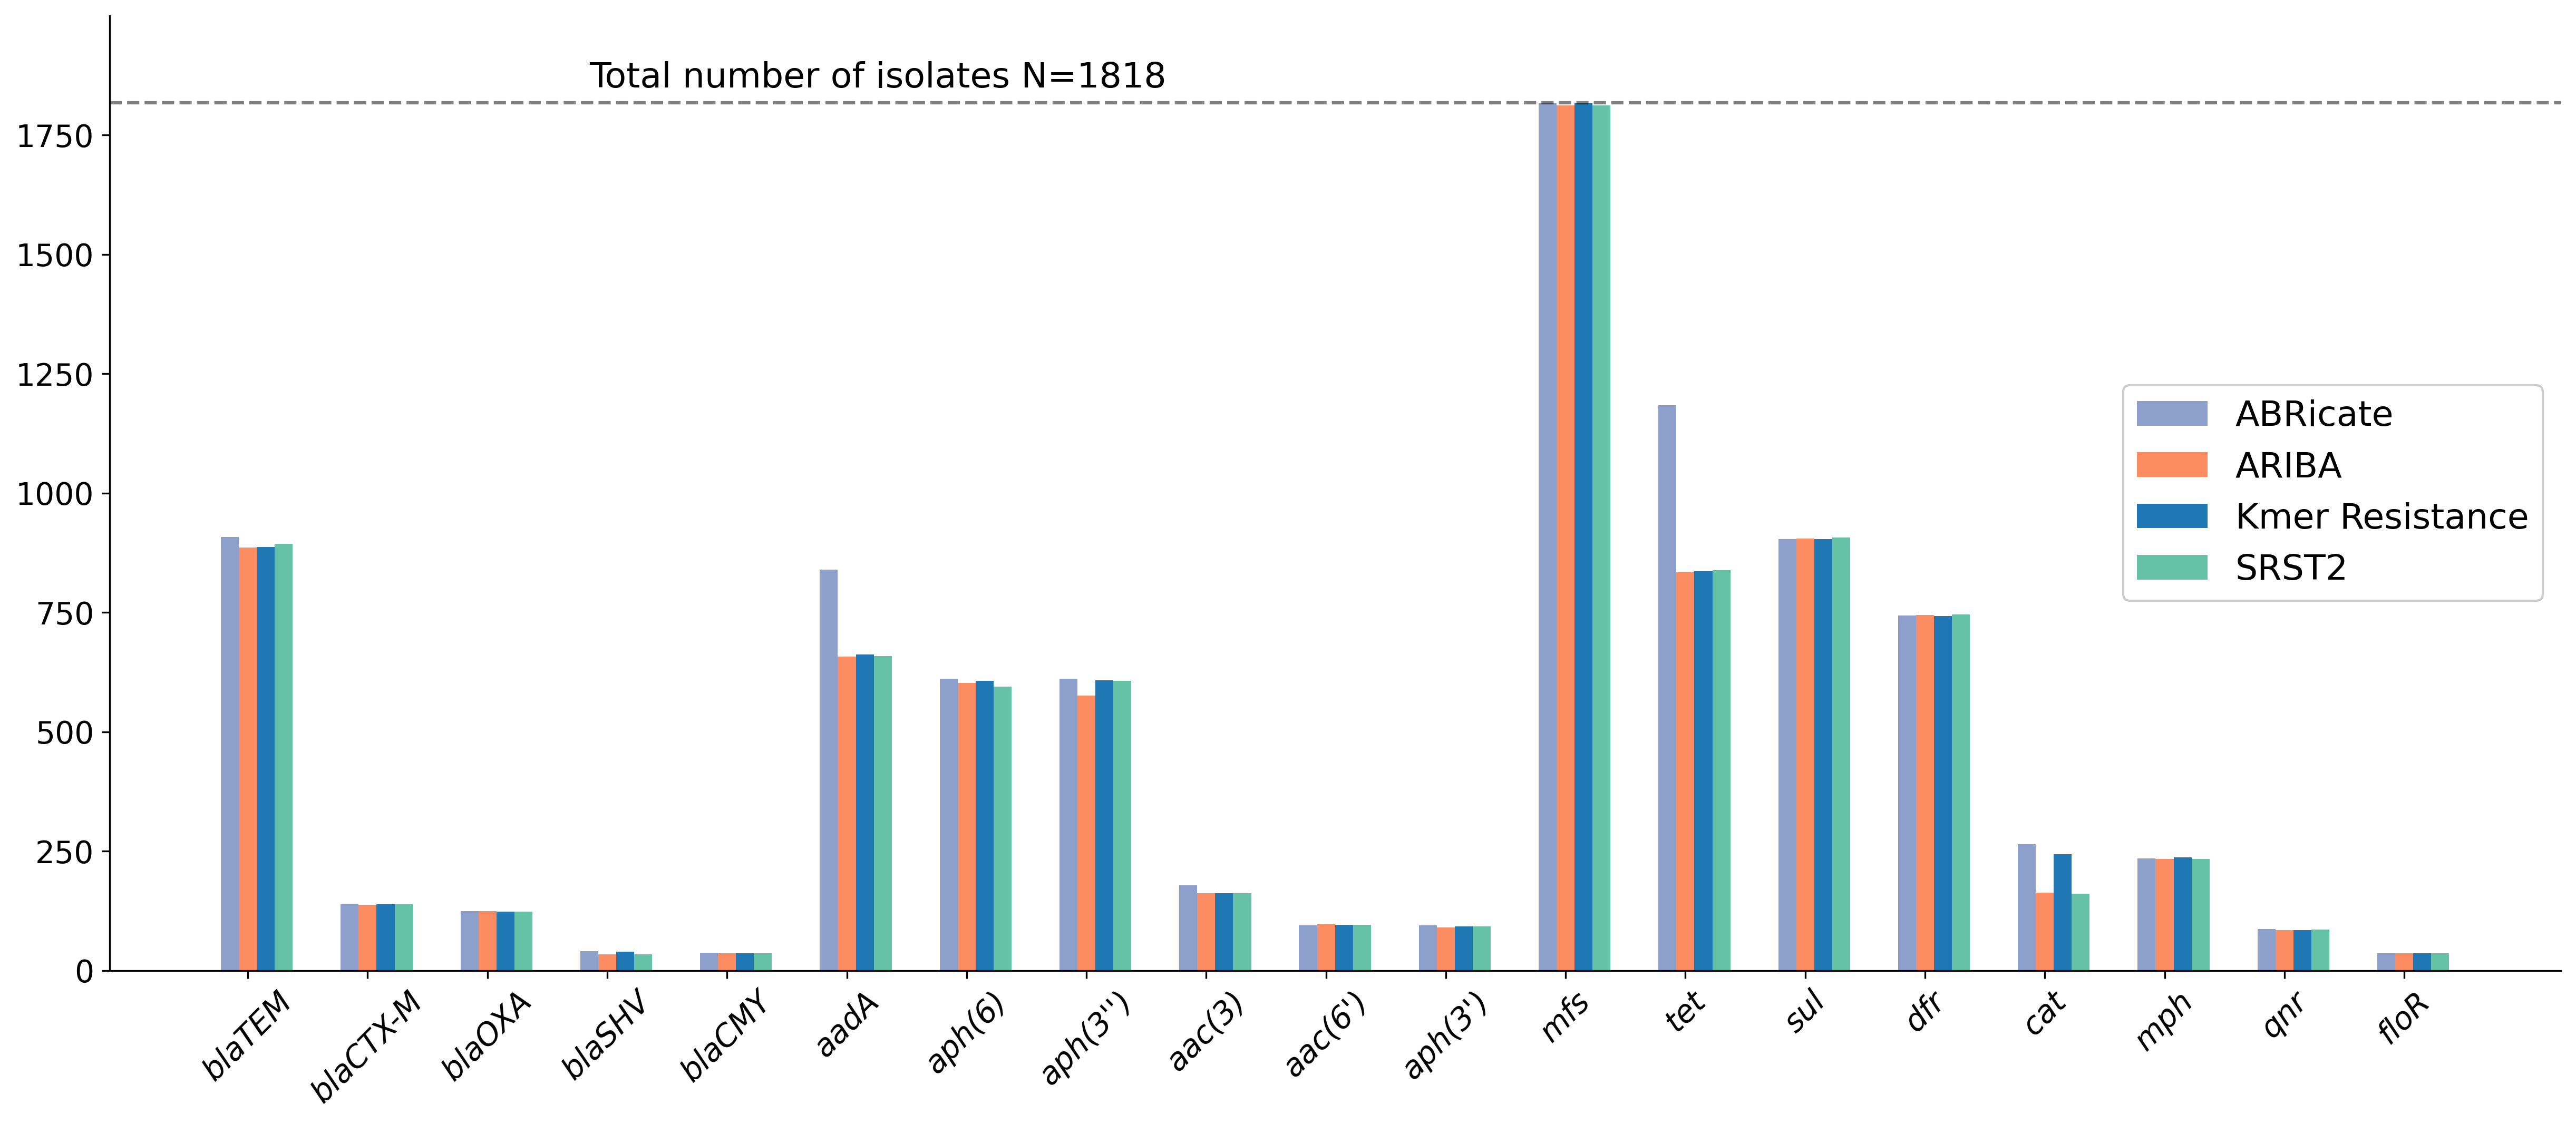

In [16]:
# =============================================================================
# Code block 7 - Producing figure 3 panel A
# =============================================================================

fig = plt.figure(figsize=(20,8), dpi=300)
ax = plt.subplot2grid((1,1),(0,0), rowspan = 1 , colspan= 1)

# For simplicity, we only look at the ones which have been found in more than 30 isolates
# To see how this affects numbers, see the chart above
pic_nos_30 = []

for k in pic_nos:
    if pic_nos[k]["all"] > 30:
        pic_nos_30.append(k)

# Next I want to sort the keys in a bit of a specific order to make the graph easier to read
blms = sorted(["blaTEM", "blaCTX-M", "blaOXA", "blaSHV", "blaCMY"], key = lambda a : pic_nos[a]['all'], reverse=True)
ami = sorted(["aadA", "aph(3')", "aph(3'')",'aph(6)','aac(3)', "aac(6')"], key = lambda a : pic_nos[a]['all'], reverse=True)
others = sorted([k for k in pic_nos_30 if k not in blms + ami], key = lambda a : pic_nos[a]['all'], reverse=True)
keys = blms + ami + others

# For each of the bars
x_0s = {}
x_1s = {}
x_2s = {}
x_3s = {}

# Putting the bars next to each other.
for k in range(len(keys)):
    x_0s[keys[k]] = k
    x_1s[keys[k]] = k+0.15
    x_2s[keys[k]] = k+0.30
    x_3s[keys[k]] = k+0.45

ax.bar([x_0s[k] for k in keys],[pic_nos[k]['abricate'] for k in keys] ,width = 0.15, label="ABRicate", 
      color = "#8da0cb")    
ax.bar([x_1s[k] for k in keys],[pic_nos[k]['ariba'] for k in keys] ,width = 0.15, label = "ARIBA", 
      color = "#fc8d62")
ax.bar([x_2s[k] for k in keys],[pic_nos[k]['kmerres'] for k in keys] ,width = 0.15, label="Kmer Resistance")  
ax.bar([x_3s[k] for k in keys],[pic_nos[k]['srst2'] for k in keys] ,width = 0.15, label="SRST2",
      color=  "#66c2a5")  

# Making the graph more inteligible
ax.set_ylim(0, 2000)
ax.set_xticks([k+0.15 for k in range(len(keys))])
ax.set_xticklabels(keys, rotation = 45, size=14, fontstyle="italic")
# ax.set_xlabel("Genes identified", size = 16)
# ax.set_ylabel("Number of isolates", size = 16)
ax.set_yticks([0, 250, 500, 750, 1000, 1250, 1500, 1750])
ax.set_yticklabels([0, 250, 500, 750, 1000, 1250, 1500, 1750], size=14)
ax.axhline(y=1818, color ="black", alpha=0.5, ls="--" )
ax.text( 3,  1850, "Total number of isolates N=1818", size=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(loc="right", prop={'size': 16}, facecolor="white", framealpha=1)

plt.show()

        

In [17]:
# To give you a numerical idea of differences between the tool
# I.e. what proportion of samples are differently called, at least at the major gene level.

# To begin with you want a dictionary without the "all" category to make this code work
restricted_pic_nos = {k:{j:pic_nos[k][j] for j in pic_nos[k] if j != "all"} for k in pic_nos}


for k in keys: # Note the keys are literally the gene names at the bottom of this graph
    # First creating a diff, i.e. counting which program call the max vs which called this minimum
    diff = max(list(restricted_pic_nos[k].values())) - min(list(restricted_pic_nos[k].values()))
    # Then making that as a proportion, and printing it , and giving you the size as a proportion of total sample size as a 
    # Note a negative difference basically means how much of the sample less than the maximum that program called
    print(k,diff, diff/1818, restricted_pic_nos[k], {j:(restricted_pic_nos[k][j] - max(list(restricted_pic_nos[k].values())))/1818 for j in restricted_pic_nos[k]})
    print("")
    
# The important bit to take away from the picture above and numbers below, is that in most cases, all programs find the same "genes"
    

blaTEM 22 0.0121012101210121 {'abricate': 908, 'ariba': 886, 'kmerres': 887, 'srst2': 894} {'abricate': 0.0, 'ariba': -0.0121012101210121, 'kmerres': -0.01155115511551155, 'srst2': -0.007700770077007701}

blaCTX-M 1 0.00055005500550055 {'abricate': 139, 'ariba': 138, 'kmerres': 139, 'srst2': 139} {'abricate': 0.0, 'ariba': -0.00055005500550055, 'kmerres': 0.0, 'srst2': 0.0}

blaOXA 1 0.00055005500550055 {'abricate': 124, 'ariba': 124, 'kmerres': 123, 'srst2': 123} {'abricate': 0.0, 'ariba': 0.0, 'kmerres': -0.00055005500550055, 'srst2': -0.00055005500550055}

blaSHV 6 0.0033003300330033004 {'abricate': 40, 'ariba': 34, 'kmerres': 39, 'srst2': 34} {'abricate': 0.0, 'ariba': -0.0033003300330033004, 'kmerres': -0.00055005500550055, 'srst2': -0.0033003300330033004}

blaCMY 1 0.00055005500550055 {'abricate': 37, 'ariba': 36, 'kmerres': 36, 'srst2': 36} {'abricate': 0.0, 'ariba': -0.00055005500550055, 'kmerres': -0.00055005500550055, 'srst2': -0.00055005500550055}

aadA 183 0.100660066006600

[Text(0, 0, '0.0'),
 Text(0, 0, '0.2'),
 Text(0, 0, '0.4'),
 Text(0, 0, '0.6'),
 Text(0, 0, '0.8'),
 Text(0, 0, '1.0')]

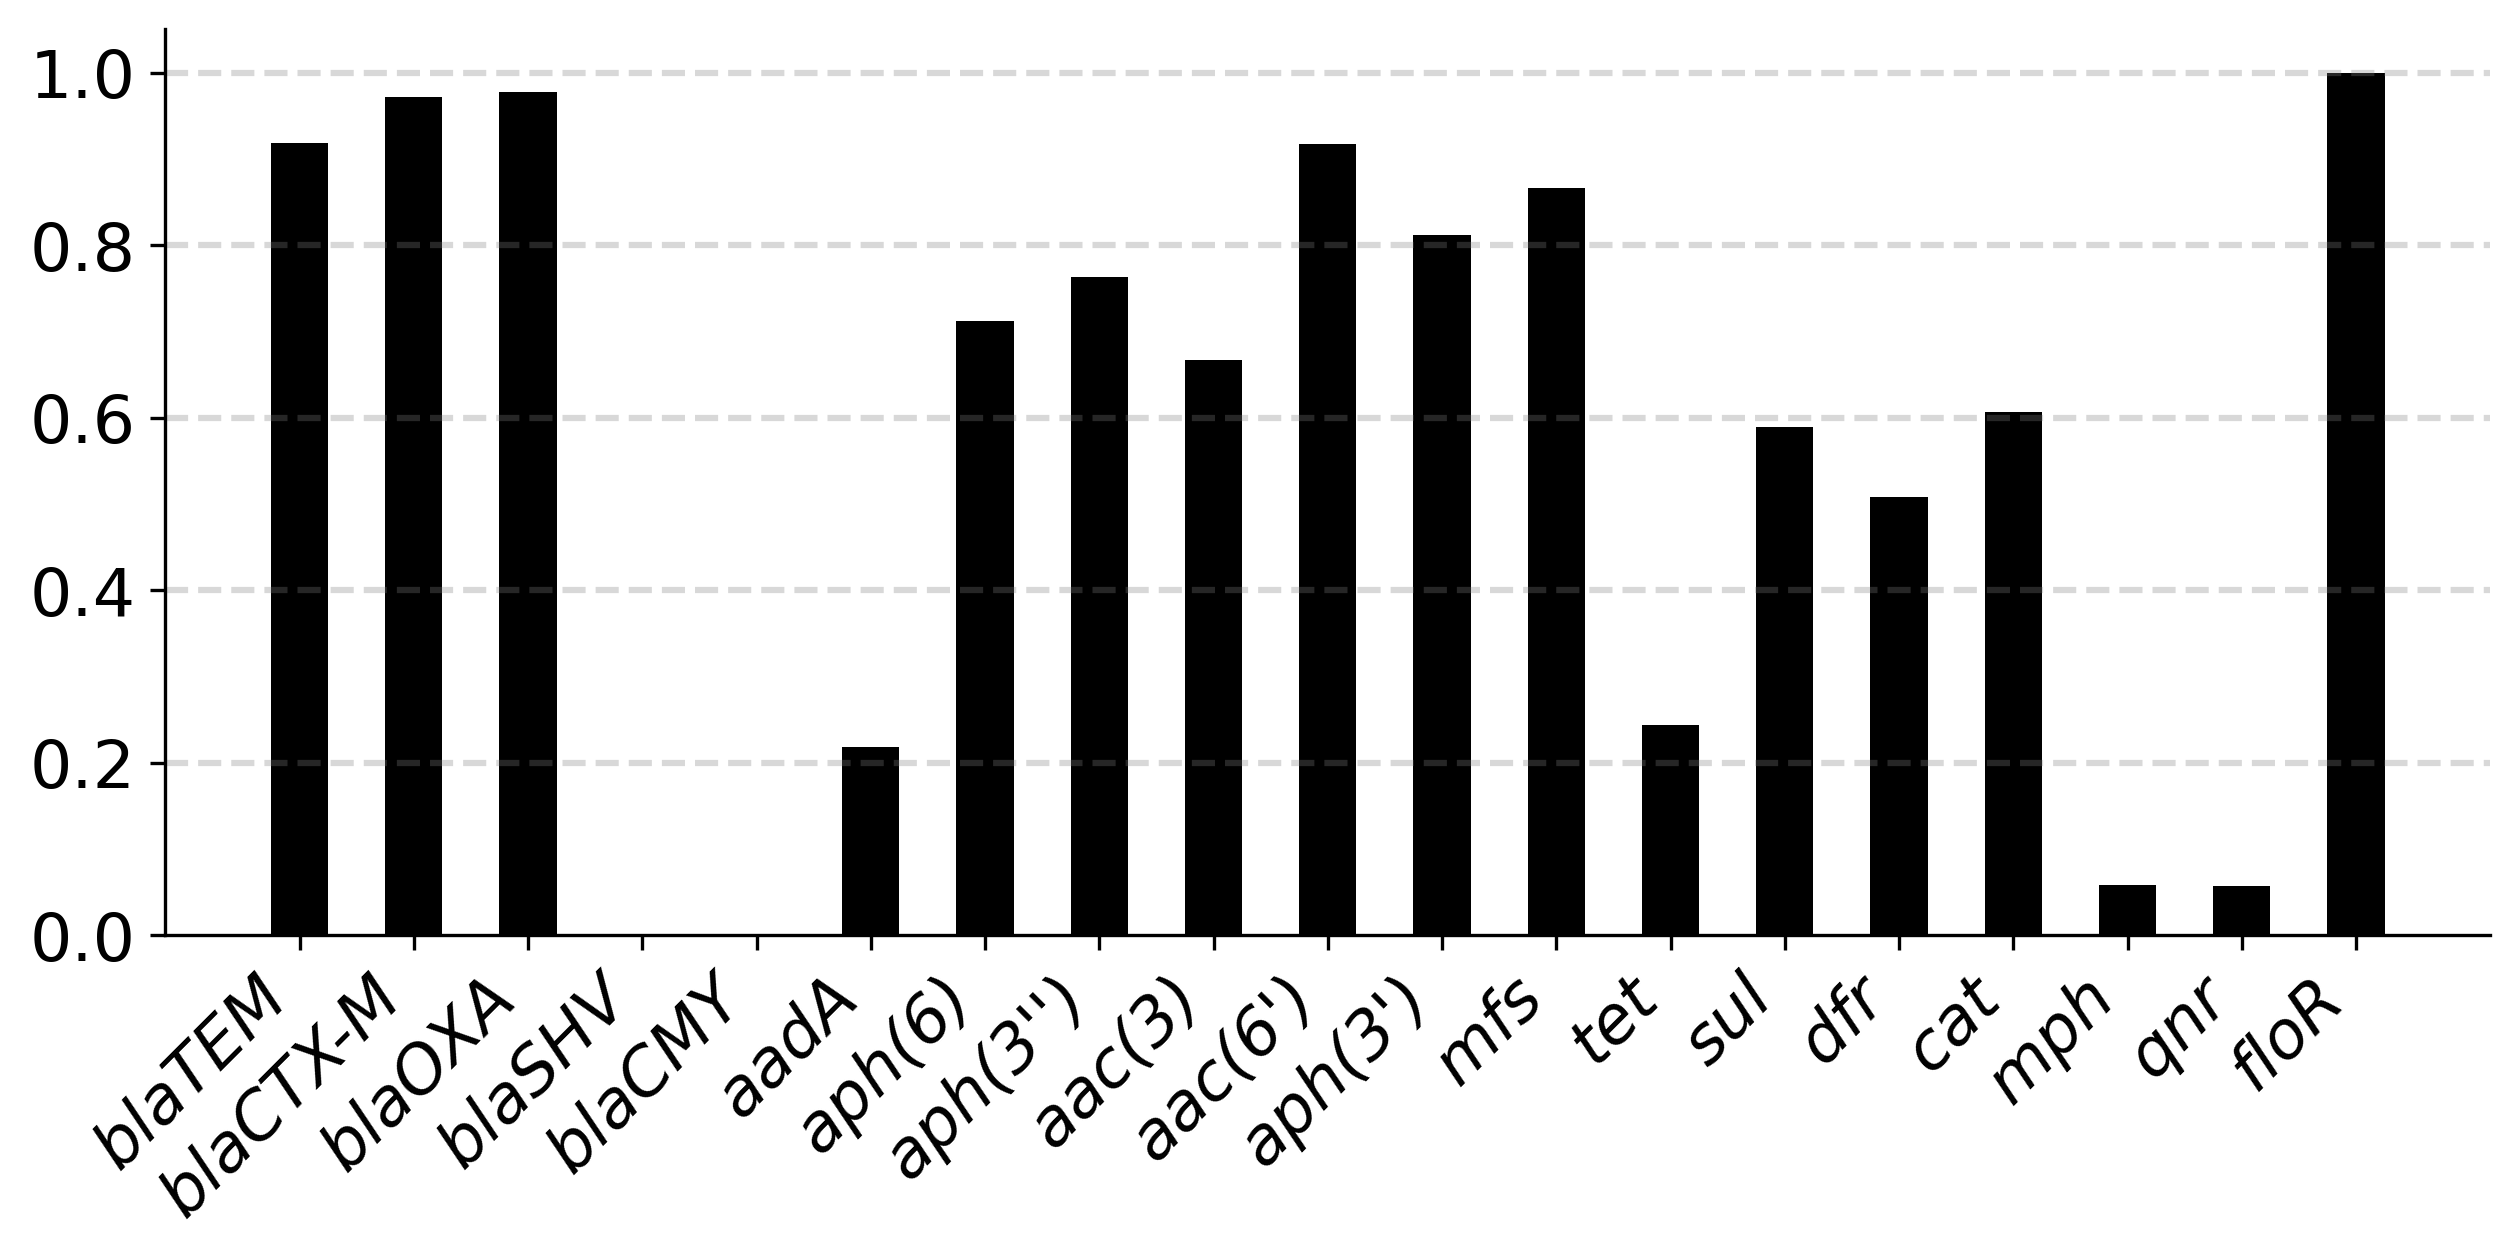

In [18]:
# However when you look directly at what has been called these are often very different.

# Now for the next panel I want to show how often each of these genes is concordant
pic_agreement = {}
for k in isolates:
    for g in isolates[k].gene_info:
        name = isolates[k].gene_info[g]["picture_family"]
        agreement = isolates[k].gene_info[g]["pattern"] == [1, 1, 1, 1]
        # This means that all programs give the same.
        if name in pic_nos_30:
            pic_agreement.setdefault(name, []).append(agreement)
pic_totalline = {k:len(pic_agreement[k]) for k in pic_agreement}
pic_agreement = {k: len([j for j in pic_agreement[k] if j == True])/len(pic_agreement[k]) for k in pic_agreement}
# Overall this creates a dictionary where the total number in agreement for each gene (in the picture above) 
# E.g. bla_TEM:100/1000 means blaTEM was in full agreement for 100/1000 (e.g. 0.1 prop) isolates

# Although keys is still in play from above, I re ut it here to remind myself.
blms = sorted(["blaTEM", "blaCTX-M", "blaOXA", "blaSHV", "blaCMY"], key = lambda a : pic_nos[a]['all'], reverse=True)
ami = sorted(["aadA", "aph(3')", "aph(3'')" ,'aph(6)','aac(3)', "aac(6')"], key = lambda a : pic_nos[a]['all'], reverse=True)
others = sorted([k for k in pic_nos_30 if k not in blms + ami], key = lambda a : pic_nos[a]['all'], reverse=True)

keys = blms + ami + others

fig = plt.figure(figsize=(10,4), dpi=300)
ax = plt.subplot2grid((1,1),(0,0), rowspan = 1 , colspan= 1)

xs = {}
for k in range(len(keys)):
    xs[keys[k]] = k

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.axhline(y=0.2, linestyle="--", alpha=0.3, color = "grey")
ax.axhline(y=0.4, linestyle="--", alpha=0.3, color = "grey")
ax.axhline(y=0.6, linestyle="--", alpha=0.3, color = "grey")
ax.axhline(y=0.8, linestyle="--", alpha=0.3, color = "grey")
ax.axhline(y=1.0, linestyle="--", alpha=0.3, color = "grey")


ax.bar([xs[k] for k in xs], [pic_agreement[k] for k in xs], width=0.5,  color="black")
ax.set_xticks([xs[k] for k in xs])
ax.set_xticklabels([k for k in xs], rotation=45, size=16, fontstyle="italic", ha="right")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], size=16)

# Now we can see from some genes, there is very low overall agreement of the 4 methods about what alleles are actually there.


['ABRicate', 'ARIBA', 'KmerRes', 'SRST2']
1818
434
533
461
434
1818
985
1065
533
985
1818
918
461
1065
918
1818
          ABRicate     ARIBA   KmerRes     SRST2
ABRicate  1.000000  0.238724  0.293179  0.253575
ARIBA     0.238724  1.000000  0.541804  0.585809
KmerRes   0.293179  0.541804  1.000000  0.504950
SRST2     0.253575  0.585809  0.504950  1.000000


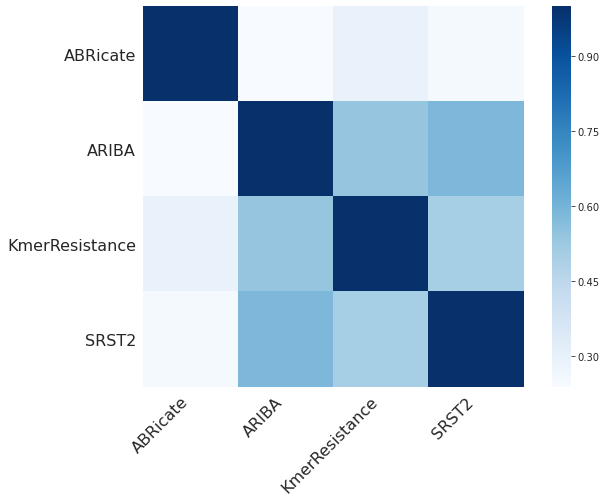

In [19]:
# Next you might wonder if it is a singular program that is doing this, however the next figure is designed to explore that a little
# Note you could do this for specific genes by thinkering with the code below. This however looks at all genes just for simplicity in this figure.
tools = ["ABRicate", "ARIBA", "KmerRes", "SRST2"]

# So to do this you generate a matrix of agreement, and then turn it into a heatmap
pairwise_agreement = pd.DataFrame(np.zeros((4,4 )), 
                                  columns = tools, index=tools)
print(tools) # To remind people what is in the tools list
for n in range(len(tools)):
    k = tools[n]
    for m in range(len(tools)):
        j = tools[m]
        # So for each paring of tools you create a list with method agreement.
        combination_list = []
        for i in isolates:
            # You start with the assumption they are in agreement
            method_agreement = True
            # Then you look at every pairwise agreement for every gene (for those two tools)
            # ************** Note if you wanted to look at a specific gene you would edit the code below. **********
            for g in isolates[i].gene_info:
                if isolates[i].gene_info[g]["pairwise"][k][j] == 0.0:
                    # If you find any disagreement, it then flicks the overall sample agreement to false
                    method_agreement = False
                else:
                    pass
            # You then append this boolean to the "combination list"
            combination_list.append(method_agreement)
        # You then use the combination list to create a proportion
        print(len([k for k in combination_list if k == True]))
        agreement = len([k for k in combination_list if k == True])/len(combination_list)
        pairwise_agreement[k][j] = agreement

print(pairwise_agreement)
# Turning the matrix into a heatmap using seaborn. 
mask = np.zeros_like(pairwise_agreement)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(pairwise_agreement, mask=mask,cmap = "Blues", square=True)
    ax.set_yticklabels(["ABRicate", "ARIBA", "KmerResistance", "SRST2"], ha="right", rotation=0, fontsize=16)
    ax.set_xticklabels(["ABRicate", "ARIBA", "KmerResistance", "SRST2"], ha="right", rotation=45, fontsize=16)
    

In [20]:
# So for each gene, you want to understand the disagreement patterns as errors are not "random" (see graph)
# This is numbers for Fig 5, note however I don't automate how this picture is made , but this produces all the numbers  you need to make it


patterns = ['1:1:1:1', '1:1:1:2', '1:1:2:1', '1:2:1:1', '1:2:2:2', '1:1:2:2', '1:2:1:2', 
            '1:2:2:1', '1:1:2:3', '1:2:1:3', '1:2:3:1', '1:2:2:3', '1:2:3:2', '1:2:3:3', '1:2:3:4']

fig_basis= {k:{p:0 for p in keys} for k in patterns}

# Now for each gene in the "keys" string (see above) , we look at the agreement pattern and then fill in the numbers in
# The fig basis dictionary

for k in isolates:
    for g in isolates[k].gene_info:
        if isolates[k].gene_info[g]["picture_family"] in keys:
            fig_basis[":".join([str(j) for j in isolates[k].gene_info[g]["pattern"]])][isolates[k].gene_info[g]["picture_family"] ] += 1


# totals column # Note this also includes all the less common genes (in addition to just the ones in the keys list)
# I.e the ones seen in less than 30 isolates
total_genes = 0
totals = {}
for k in isolates:
    for g in isolates[k].gene_info:
        total_genes += 1
        pat = ":".join([str(m) for m in isolates[k].gene_info[g]["pattern"]])
        if pat not in totals.keys():
            totals[pat] = 0
        totals[pat] += 1

# comparing how many this doesn't include , we use below
for k in fig_basis:
    print(k, fig_basis[k],np.sum([p for p in fig_basis[k].values()]), totals[k])
    print("")      

    
# Just looking at home many genes are called discrepantly
print("discrepant calls", np.sum([p for p in totals.values()]) -totals["1:1:1:1"])    
print("concordant calls", totals["1:1:1:1"])
print("total genes", total_genes) # 10487 genes called, see above for some totals

#
#
###### TO GET THE NUMBERS FOR A PARTICULAR COLUMN, PLEASE USE THE FOLLOWING! #########
#
#
print("")
print("")

g = "blaTEM"
print(g)

for k in sorted(list(totals.keys()), key = lambda a : totals[a], reverse=True) :
    print(k, fig_basis[k][g])
    

1:1:1:1 {'blaTEM': 842, 'blaCTX-M': 135, 'blaOXA': 127, 'blaSHV': 0, 'blaCMY': 0, 'aadA': 241, 'aph(6)': 439, "aph(3'')": 468, 'aac(3)': 124, "aac(6')": 89, "aph(3')": 82, 'mfs': 1829, 'tet': 409, 'sul': 687, 'dfr': 402, 'cat': 168, 'mph': 14, 'qnr': 5, 'floR': 36} 6097 6166

1:1:1:2 {'blaTEM': 4, 'blaCTX-M': 0, 'blaOXA': 1, 'blaSHV': 0, 'blaCMY': 32, 'aadA': 1, 'aph(6)': 1, "aph(3'')": 0, 'aac(3)': 0, "aac(6')": 0, "aph(3')": 0, 'mfs': 140, 'tet': 5, 'sul': 31, 'dfr': 178, 'cat': 2, 'mph': 0, 'qnr': 79, 'floR': 0} 474 501

1:1:2:1 {'blaTEM': 5, 'blaCTX-M': 1, 'blaOXA': 0, 'blaSHV': 0, 'blaCMY': 0, 'aadA': 0, 'aph(6)': 0, "aph(3'')": 0, 'aac(3)': 15, "aac(6')": 0, "aph(3')": 0, 'mfs': 0, 'tet': 1, 'sul': 0, 'dfr': 0, 'cat': 0, 'mph': 0, 'qnr': 0, 'floR': 0} 22 22

1:2:1:1 {'blaTEM': 13, 'blaCTX-M': 0, 'blaOXA': 1, 'blaSHV': 0, 'blaCMY': 0, 'aadA': 1, 'aph(6)': 44, "aph(3'')": 88, 'aac(3)': 0, "aac(6')": 0, "aph(3')": 11, 'mfs': 8, 'tet': 8, 'sul': 2, 'dfr': 1, 'cat': 0, 'mph': 0, 'qnr'

{'blm': {'ABRicate': 74, 'ARIBA': 61, 'KmerRes': 38, 'SRST2': 81}, 'ami': {'ABRicate': 955, 'ARIBA': 460, 'KmerRes': 152, 'SRST2': 457}, 'qui': {'ABRicate': 2, 'ARIBA': 0, 'KmerRes': 0, 'SRST2': 80}, 'tri': {'ABRicate': 174, 'ARIBA': 61, 'KmerRes': 86, 'SRST2': 267}, 'sul': {'ABRicate': 404, 'ARIBA': 13, 'KmerRes': 10, 'SRST2': 52}}
{'blm': 1273, 'ami': 2754, 'qui': 88, 'tri': 792, 'sul': 1165}


Text(0, 0.5, 'Number of genotype \n calls supported \n by a single method')

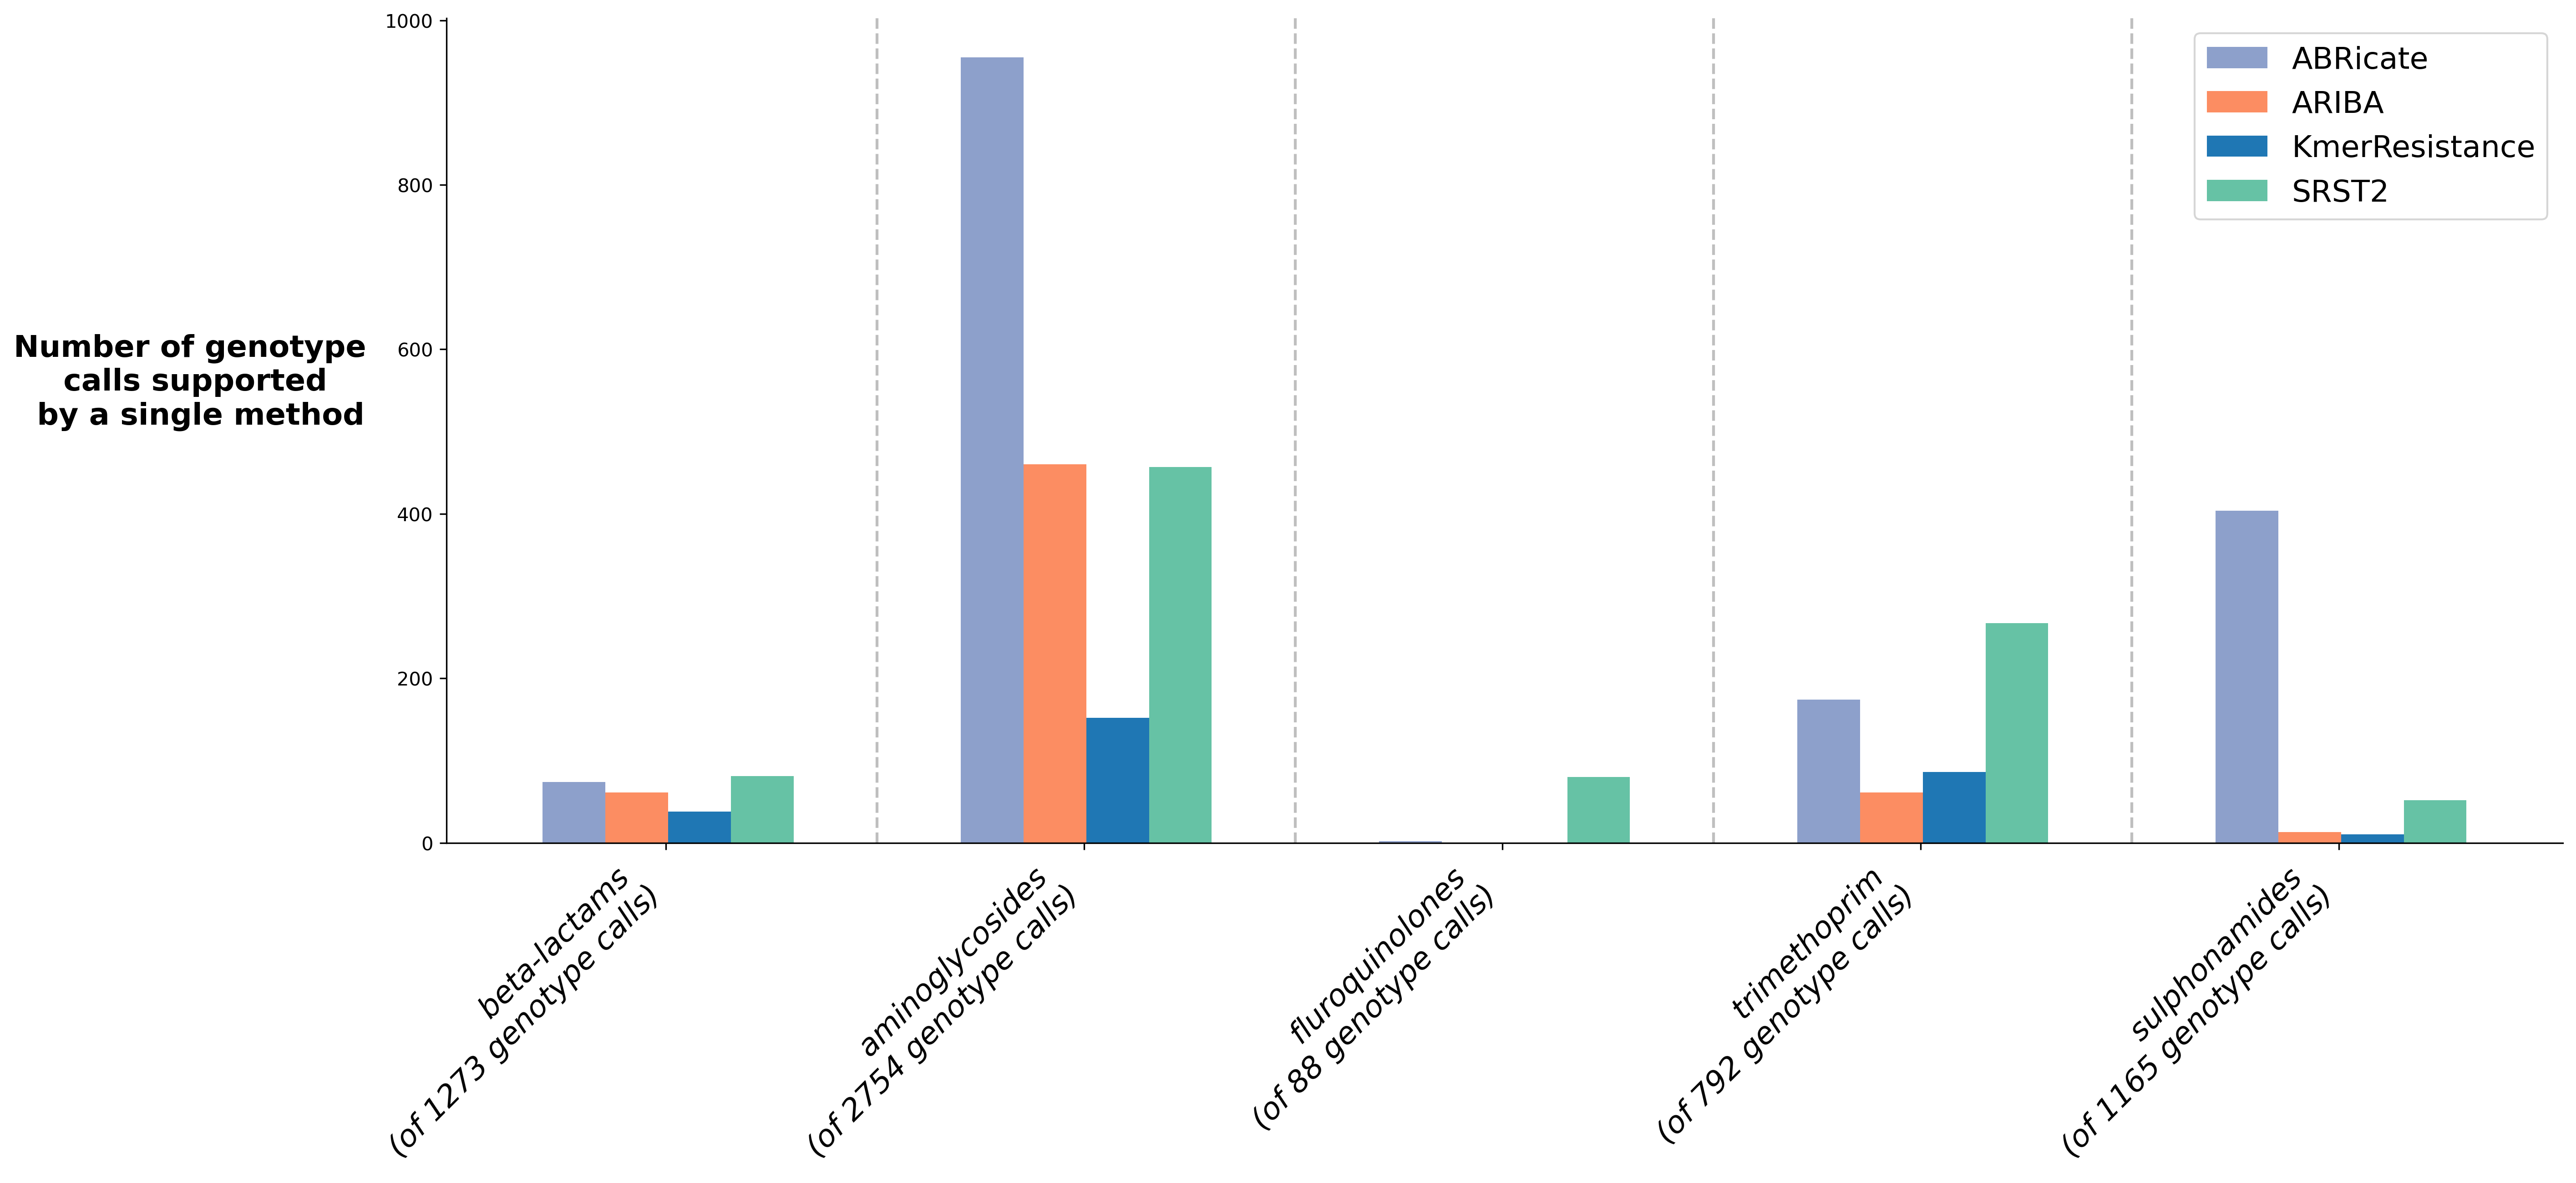

In [21]:
# Figure 4
# This looks for how often individual tools produe a report about a "gene" which isn't supported by any of the other tools

solo_support = {"blm":{"ABRicate":0, "ARIBA":0, "KmerRes":0, "SRST2":0}, 
               "ami":{"ABRicate":0, "ARIBA":0, "KmerRes":0, "SRST2":0},
                "qui":{"ABRicate":0, "ARIBA":0, "KmerRes":0, "SRST2":0}, 
                "tri":{"ABRicate":0, "ARIBA":0, "KmerRes":0, "SRST2":0}, 
                "sul":{"ABRicate":0, "ARIBA":0, "KmerRes":0, "SRST2":0}}
totals = {"blm":0, "ami":0, "qui":0, "tri":0, "sul":0}
# Note importantly, an isolate can have multiple genes affecting a single phenotype
# These totals are litterally just the number of "genes" related to that specific phenotype

# Similar tricks to before using parewise comparisons
poss_rel_phenotypes = []
for k in isolates:
    for g in isolates[k].gene_info:
        if isolates[k].gene_info[g]["relative_phenotype"] in list(solo_support.keys()):
            totals[isolates[k].gene_info[g]["relative_phenotype"] ] +=1
            for tool1 in ["ABRicate", "ARIBA", "KmerRes", "SRST2"]:
                tool1_solo = True
                for tool2 in ["ABRicate", "ARIBA", "KmerRes", "SRST2"]:
                    if tool1 != tool2 and isolates[k].gene_info[g]["pairwise"][tool1][tool2] == 1.0:
                        tool1_solo = False
                if tool1_solo == True:
                    solo_support[isolates[k].gene_info[g]["relative_phenotype"]][tool1] += 1

print(solo_support)
print(totals)

fig = plt.figure(figsize=(20,8), dpi=300)
ax = plt.subplot2grid((1,1),(0,0), rowspan = 1 , colspan= 1)

fkeys = ["blm", "ami", "qui", "tri", "sul"]

x_0s = {}
x_1s = {}
x_2s = {}
x_3s = {}

for k in range(len(fkeys)):
    x_0s[fkeys[k]] = k
    x_1s[fkeys[k]] = k+0.15
    x_2s[fkeys[k]] = k+0.30
    x_3s[fkeys[k]] = k+0.45

# Uncomment out the line below if you want to check by tool the exact numbers in the graph
# Change the tool as desired
# print([solo_support[k]["ABRicate"] for k in fkeys])

ax.bar([x_0s[k] for k in fkeys], [solo_support[k]["ABRicate"] for k in fkeys], width = 0.15, 
      color = "#8da0cb", label="ABRicate")
ax.bar([x_1s[k] for k in fkeys], [solo_support[k]["ARIBA"] for k in fkeys], width = 0.15, 
      color = "#fc8d62", label="ARIBA")
ax.bar([x_2s[k] for k in fkeys], [solo_support[k]["KmerRes"] for k in fkeys], width = 0.15, 
      label="KmerResistance")
ax.bar([x_3s[k] for k in fkeys], [solo_support[k]["SRST2"] for k in fkeys], width = 0.15, 
      color="#66c2a5", label="SRST2")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(fontsize=16)
ax.set_xticks([k+0.22 for k in range(len(fkeys))])
new_fkeys = ["beta-lactams \n (of {0} genotype calls)".format(totals["blm"]), "aminoglycosides \n (of {0} genotype calls)" .format(totals["ami"]), 
             "fluroquinolones \n (of {0} genotype calls)" .format(totals["qui"]), "trimethoprim \n (of {0} genotype calls)" .format(totals["tri"]), 
            "sulphonamides \n (of {0} genotype calls)".format(totals["sul"])]
ax.set_xticklabels(new_fkeys, rotation = 45, size=16, fontstyle="italic", ha="right")
ax.axvline(x=0.725, color="grey", linestyle="--", alpha=0.5)
ax.axvline(x=1.725, color="grey", linestyle="--", alpha=0.5)
ax.axvline(x=2.725, color="grey", linestyle="--", alpha=0.5)
ax.axvline(x=3.725, color="grey", linestyle="--", alpha=0.5)
ax.set_ylabel("Number of genotype \n calls supported \n by a single method", rotation=0, size=16, ha="center", 
              labelpad=100, weight="bold")





## *
## *
## *
## *
# Investigation of Discrepants: Sample methodology with comments
## *
## *
## *
## *
## *


In [22]:
# So now we have all of the Figures
# next is to look at the patterns for each gene
# So the first useful thing is to remind ourselves of the gene_info dict.
# Of note as we are exploring real data here, it makes sense to try and map things back to original families 
# (as opposed to our kmer based method which we did for the simulation)
# This is because we want our results to make real life sense as opposed to be a technical demonstration of the program


def esc(code):
    return f'\033[{code}m'

def rb_highlight(s):
    print(esc('31;1;4') + s + esc(0))

for k in isolates:
    for g in isolates[k].genes_identified:
        rb_highlight(g)
        for key in isolates[k].gene_info[g]:
            print(key)
            print(isolates[k].gene_info[g][key])
            print("")
        print("")
    break


aadA11_2_AJ567827:aadA12_1_AY665771:aadA17_1_FJ460181:aadA1_3_JQ414041:aadA24_1_AM711129:ant(3'')-Ia_1_X02340
pattern
[1, 2, 1, 3]

presence_absence
0:0:0:0:0:1|0:0:0:1:0:0|0:0:0:0:0:1|1:1:1:1:1:0

gene_family
aadA11_2_AJ567827:aadA12_1_AY665771:aadA13_1_AY713504:aadA13_2_NC010643:aadA15_1_DQ393783:aadA17_1_FJ460181:aadA1_2_FJ591054:aadA1_3_JQ414041:aadA1_4_JQ480156:aadA1_5_JX185132:aadA1b_1_M95287:aadA21_1_AY171244:aadA22_1_AM261837:aadA23_1_AJ809407:aadA24_1_AM711129:aadA24_1_DQ677333:aadA2_1_NC_010870:aadA2_2_JQ364967:aadA2b_1_D43625:aadA3_1_AF047479:aadA8b_1_AY139603:aadA8b_2_AM040708:ant(3'')-Ia_1_X02340

kmer_family
blaTEM-143_1_DQ075245:ARR-2_1_HQ141279:ARR-3_1_JF806499:ARR-3_4_FM207631:blaTEM-1A_1_HM749966:blaTEM-1B_1_AY458016:blaTEM-1C_1_FJ560503:blaTEM-1D_1_AF188200:blaTEM-206_1_KC783461:aac(3)-Ia_1_X15852:aac(3)-Ib_1_L06157:blaTEM-207_1_KC818234:aac(6')-Ib-Hangzhou_1_FJ503047:aac(6')-Ib-cr_1_DQ303918:aac(6')-Ib-cr_2_EF636461:aac(6')-Ib11_1_AY136758:aac(6')-Ib3_1_X60321:aac(6

In [23]:
# So we can get from this, for each gene and its presence absence pattern

# To start here I am initialising a lot of dictionaries which will all have the "gene" as identified in the dataset as keys.

gene_outputs = {}
gene_abx = {}
gene_pats = {}
gene_totals = {}
# This one is just the picture family name again to simplify
gene_name = {}

for k in isolates:
    for g in isolates[k].genes_identified:
        # First removing patterns with agreement to make things simpler (we are now analysing discrepants only for the remainder of this notebook)
        if isolates[k].gene_info[g]["pattern"] != [1,1,1,1]:
            gene_outputs.setdefault(g, []).append(isolates[k].gene_info[g]['presence_absence'])
            gene_pats.setdefault(g, []).append(":".join([str(k) for k in isolates[k].gene_info[g]['pattern']]))
            # Note technically the relative phenotype will and totals will always have a singular answer, so can read it from the fits one
            if g not in gene_abx.keys():
                gene_abx[g] = isolates[k].gene_info[g]['relative_phenotype']
            else:
                assert gene_abx[g] == isolates[k].gene_info[g]['relative_phenotype']
            if g not in gene_name.keys():
                gene_name[g] = isolates[k].gene_info[g]['picture_family']
            else:
                assert gene_name[g] == isolates[k].gene_info[g]['picture_family']
            if g not in gene_totals:
                gene_totals[g] = 0
            gene_totals[g] +=1

# Taking an example, blaSHV
for g in sorted(gene_pats, key = lambda a : len(gene_pats[a]), reverse = True):
    if gene_name[g] == "blaSHV":
        print(g, Counter(gene_pats[g]), Counter(gene_outputs[g]))
        print("")
        
# Now looking at this text, you can see several things
# First point is how how complex a discordance call can be
# E.g. for the blaSHV pattern
# blaLEN12_1_AJ635406:blaSHV-100_1_AM941846:blaSHV-153_1_JX121120:blaSHV-1_1_AF148850:blaSHV-48_1_AY263404
# This has been seen 12 times throughout the dataset
# This has never been seen in agreement, but within that there are complxities with how it is called
# ABRicate always just calls blaSHV-48
# KmerResistance always calls blaSHV-1
# ARIBA calls either [blaSHV-153_1_JX121120, blaSHV-48_1_AY263404] (6 occurences) or [blaSHV-153_1_JX121120, blaSHV-1_1_AF148850] (5 occurences)
# SRST2 calls blaLEN12_1_AJ635406, blaSHV-100_1_AM941846 plus either blaSHV-1_1_AF148850 (11 occurences), or [blaSHV-48_1_AY263404]

# However, within this there are patterns
# ARIBA and SRST2 always call multiple alleles, which are highly related
# ABRicate always calls 1 subtype and KmerResistance always calls another

# Looking at how each one finds each allele gives us clues as to why these things would be different

# Essentially a lot of the subsequent work in the paper does this, but it is manual 
# Hence I will dig into individual examples here

# I will try to classify things as clear # Annotation errors, where each program finds the same underlying sequence but ends up calling things differently
# This includes things like nested sequences which are differentially called, mapping errors where multiple alleles are called
# These are definitively artefactual

# Vs non-classification errors, where due to how the program processes the reads they see fundamentally different data
# Examples of this are when an assembler fails assemble a sequence
# Cut-off choices tend to have a big impact on how these are processed

blaLEN12_1_AJ635406:blaSHV-100_1_AM941846:blaSHV-153_1_JX121120:blaSHV-1_1_AF148850:blaSHV-48_1_AY263404 Counter({'1:2:3:4': 12}) Counter({'0:0:0:0:1|0:0:1:0:1|0:0:0:1:0|1:1:0:1:0': 6, '0:0:0:0:1|0:0:1:1:0|0:0:0:1:0|1:1:0:1:0': 5, '0:0:0:0:1|0:0:1:0:1|0:0:0:1:0|1:1:0:0:1': 1})

blaLEN12_1_AJ635406:blaSHV-100_1_AM941846:blaSHV-102_1_EU024485:blaSHV-153_1_JX121120:blaSHV-1_1_AF148850:blaSHV-48_1_AY263404 Counter({'1:2:3:4': 5, '1:2:1:3': 1}) Counter({'0:0:0:0:0:1|0:0:1:1:0:0|0:0:0:0:1:0|1:1:0:0:1:0': 4, '0:0:0:0:0:1|0:0:1:1:0:0|0:0:0:0:1:0|1:1:0:0:0:1': 1, '0:0:0:0:0:1|0:0:1:1:0:0|0:0:0:0:0:1|1:1:0:0:1:0': 1})

oqxB_1_EU370913 Counter({'1:2:1:2': 5, '1:2:2:2': 1}) Counter({'1|0|1|0': 5, '1|0|0|0': 1})

blaLEN17_1_EF205593:blaSHV-100_1_AM941846:blaSHV-153_1_JX121120:blaSHV-1_1_AF148850:blaSHV-48_1_AY263404 Counter({'1:2:3:4': 4}) Counter({'0:0:0:0:1|0:0:1:0:1|0:0:0:1:0|1:1:0:1:0': 2, '0:0:0:0:1|0:0:1:1:0|0:0:0:1:0|1:1:0:1:0': 2})

blaSHV-100_1_AM941846:blaSHV-12_1_KF976405:blaSHV-154_1_JX

In [24]:
# So now you can break things down to make them easier to read and understand
# To do this we look at genes (as we would commonly understand them) and pattern combinations. This then aligns things with figure 5
# Of note an alternative would be to look at every pattern called, but this is complex and while informative is difficult to parse for a casual reader
# Given the point of this work is to highlight how errors are not random, but instead there are strong patterns determined by how each program functions
# It doesn't need the level of detail of going through every indificual pattern of calling

# blaTEM 1:2:2:2 = Not definitively a sequencing classification error (0/35)
# blaTEM 1:2:1:1 = Not definitively a sequencing classification error (0/13)
# blaSHV 1:2:1:3 = Multiple mapping (9/10)
# blaSHV 1:2:3:4 = Multiple mapping + DNA Matching (24/24)
# blaCMY 1:1:1:2 = Multiple mapping (32/32)
# aadA 1:2:2:2 = Likely cutoffs and picking up an insertion sequence however by our definition, not a sequence classification error (0/416)
# aadA 1:2:1:3 =  nested sequences, multiple mapping, Greedy algorithm (124/124)
# aadA 1:2:2:3 = nested sequences, multiple mapping, Greedy algorithm (180/180)
# aadA 1:2:3:4 = aadA 1:2:3:4 =  nested sequences, multiple mapping, Greedy algorithm (132/132)
# aph(6) 1:2:2:2 = Best_match length (105/112)
# aph(6) 1:2:1:1 = Not definitively artefact (0/44)
# aph(6) 1:2:1:3 = Not definitively artefact (0/11)
# aph(3'') 1:2:2:2 = Not definitively artefact (0/15)
# aph(3'') 1:2:1:1 =  DNA matching (88/88)
# aph(3'') 1:2:3:3 = Not definitively artefact (0/35)
# aac(3) 1:2:2:2 = Nested sequences (31/47)
# aph(3') 1:1:2:1 = DNA matching (10/11)
# mfs 1:2:2:2 = Likely cutoffs and picking up an insertion sequence however by our definition, not a sequence classification error (0/131)
# mfs 1:1:1:2 = Multiple mapping 140/140
# sul 1:1:1:2 = Best_match length 30/31
# sul 1:2:2:2 = Best_match length 362/376
# sul 1:2:1:2 = Best_match length 36/39
# sul 1:2:2:3 = Not definitively artefact
# tet 1:2:2:2 = Likely cutoffs and picking up an insertion sequence however by our definition, not a sequence classification error (0/780)
# tet 1:1:2:3 = Multiple mapping, winner takes all
# tet 1:2:1:2 = "Best_match length" (439/439)
# dfr 1:1:1:2 = "clustering" (178/178)
# dfr 1:2:2:2 = "Best_match length" (111/111)
# dfr 1:1:2:3 = "Multiple mapping", "DNA matching", "Winner takes all" 28/28
# dfr 1:2:3:4 = "Multiple mapping", "DNA matching", "Winner takes all" 57/57
# cat 1:2:2:2 =  Cutoffs (22/22)
# cat 1:2:3:2 = "Cutoffs" (81/81)
# mph 1:2:2:2 = "Database curation" 218/218
# qnr 1:1:1:2 = "Multiple mapping (79/79)"

seq_db = {k.id:str(k.seq) for k in SeqIO.parse("../db_preparation/resfinder_20191001/db.fasta", "fasta")}


In [25]:
#Useful investigation functions

# This function gives all the genes with a particular pattern
# It also returns a list of all alleles found with that corresponding pattern
def pr_genes(fam, pat):
    rb_highlight("Gene:{0}" .format(fam))
    gene_return = []
    for k in isolates:
        # Pat of the form [1,2,3,4], fam is the picture family
        for g in isolates[k].gene_info:
            if isolates[k].gene_info[g]["picture_family"] == fam and isolates[k].gene_info[g]["pattern"] == pat:
                print(g, isolates[k].gene_info[g]["presence_absence"])
                for l in g.split(":"):
                    gene_return.append(l)
    gene_return = sorted(list(set(gene_return)))
    return gene_return
  
# This function gives, by tool, all the samples and how the tool called it (local identifiers)
def pr_genes_tool(fam, pat, tool):
    if tool == "ABRicate":
        m = 0
    if tool == "ARIBA":
        m = 1
    if tool == "KmerResistance":
        m = 2
    if tool == "SRST2":
        m = 3
    output = []
    for k in isolates:
        # Pat of the form [1,2,3,4], fam is the picture family
        for g in isolates[k].gene_info:
            if isolates[k].gene_info[g]["picture_family"] == fam and isolates[k].gene_info[g]["pattern"] == pat:
                pr_hits = []
                for r in range(len(g.split(":"))):
                    if isolates[k].gene_info[g]["presence_absence"].split("|")[m].split(":")[r] == "1":
                        pr_hits.append(g.split(":")[r])
                pr_hits = sorted(pr_hits)
                print(k, tool, pr_hits)
                output.append(k)
    return output


def get_output(i, g_list, tool):
    # This function gets the output from a specific tool about a specific allele or set of alleles
    # It returns its dataframe
    genes_dict = {g: rlink.loc[g][0] for g in g_list}
    for m in genes_dict:
        print(m,"denoted as", genes_dict[m])
    if tool == "ABRicate":
        if g_list == []:
            output_fl = isolates[i].abricate_fl
        else:
            output_fl = isolates[i].abricate_fl[isolates[i].abricate_fl['GENE'].isin(list(genes_dict.values()))]
    if tool == "KmerResistance":
        if g_list == []:
            output_fl = isolates[i].kmerres_fl
        else:
            output_fl = isolates[i].kmerres_fl[isolates[i].kmerres_fl['#Template'].isin(list(genes_dict.values()))]
    if tool == "SRST2":
        if g_list == []:
            output_fl = isolates[i].srst2_fl
        else:
            output_fl = isolates[i].srst2_fl[isolates[i].srst2_fl['allele'].isin(list(genes_dict.values()))]
    if tool == "ARIBA":
        # To get this I am going to need the full ARIBA results given above works on the summary file alone.
        output_fl = pd.read_csv("ariba_output/{0}_1.expandedreport.tsv" .format(i), delimiter = "\t")
        if g_list == []:
            pass
        else:
            output_fl = output_fl[output_fl['ref_name'].isin(list(genes_dict.values()))]
    return output_fl

# This function goes through what the output of the flexibility simulation was when a given gene g was used as the basis for the simulation
# I.e. if you create a simple bit of sequence with that gene in and simulate reads from it, what did the tool report back
# First you need what should be correct

flex_sims = pd.read_csv("flex_correct.csv")

def compare_with_sim(g, tool):
    print(g, "relates to",rlink.loc[g][0] )
    g = rlink.loc[g][0]
    output = list(flex_sims.loc[flex_sims["correct"] == g]['sequence'])[0]
    if tool == "ABRicate":
        flex_report = pd.read_csv("flex1_output/abricate_summary/{0}_assem.tab" .format(output), delimiter = "\t")
    if tool == "ARIBA":
        flex_report = pd.read_csv("flex1_output/ariba_summary/{0}.expandedreport.tsv" .format(output), delimiter = "\t")
    if tool == "KmerResistance":
        flex_report = pd.read_csv("flex1_output/kmerres_summary/{0}.KmerRes" .format(output), delimiter = "\t")
    if tool == "SRST2":
        flex_report = pd.read_csv("flex1_output/srst2_summary/{0}_SRST.out__fullgenes__seqs_clustered__results.txt" .format(output), delimiter = "\t")
    return flex_report
    
    
    


In [26]:
# These just enable us to quickly query gene and pattern (this is the level we are analysing things at)
pr_genes("blaSHV", [1,2,1,3])
print("")
pr_genes_tool("blaSHV", [1,2,1,3], "ABRicate")
get_output(i="1a7c8b4e-3fad-467c-b719-e7e9b98e8c47", tool="ARIBA", g_list=['blaSHV-12_1_KF976405'])
compare_with_sim(g='blaSHV-12_1_KF976405', tool="ABRicate")
# So we can see from this, a complex pattern but in almost all of these ABRicate calls blaSHV 12
# There is 1 anomaly, this comes from grouping things together
# but we can see marked consistency in results
# And sure enough on looking at the simulation of gene blaSHV-12, SRST2 calls 2 results

Gene:blaSHV
blaSHV-100_1_AM941846:blaSHV-12_1_KF976405:blaSHV-165_1_JX121131 0:1:0|0:1:1|0:1:0|1:1:0
blaSHV-165_1_JX121131:blaSHV-100_1_AM941846:blaSHV-12_1_KF976405 0:0:1|1:0:1|0:0:1|0:1:1
blaSHV-100_1_AM941846:blaSHV-12_1_KF976405:blaSHV-165_1_JX121131 0:1:0|0:1:1|0:1:0|1:1:0
blaSHV-12_1_KF976405:blaSHV-154_1_JX121121:blaSHV-100_1_AM941846 1:0:0|1:1:0|1:0:0|1:0:1
blaSHV-100_1_AM941846:blaSHV-12_1_KF976405:blaSHV-154_1_JX121121 0:1:0|0:1:1|0:1:0|1:1:0
blaSHV-100_1_AM941846:blaSHV-12_1_KF976405:blaSHV-154_1_JX121121 0:1:0|0:1:1|0:1:0|1:1:0
blaSHV-100_1_AM941846:blaSHV-12_1_KF976405:blaSHV-154_1_JX121121 0:1:0|0:1:1|0:1:0|1:1:0
blaSHV-165_1_JX121131:blaSHV-100_1_AM941846:blaSHV-12_1_KF976405 0:0:1|1:0:1|0:0:1|0:1:1
blaSHV-100_1_AM941846:blaSHV-12_1_KF976405:blaSHV-154_1_JX121121 0:1:0|0:1:1|0:1:0|1:1:0
blaLEN12_1_AJ635406:blaSHV-100_1_AM941846:blaSHV-102_1_EU024485:blaSHV-153_1_JX121120:blaSHV-1_1_AF148850:blaSHV-48_1_AY263404 0:0:0:0:0:1|0:0:1:1:0:0|0:0:0:0:0:1|1:1:0:0:1:0

1a7c8b4e-3f

,#FILE,SEQUENCE,START,END,GENE,COVERAGE,COVERAGE_MAP,GAPS,%COVERAGE,%IDENTITY,DATABASE,ACCESSION,PRODUCT
0,flex_431_assem.fa,NODE_1_length_2858_cov_19.932039,999,1859,resfindernewid_2173,1-861/861,===============,0/0,100.0,100.0,resfinderformatted,2173,resfinderformatted~~~resfindernewid_2173~~~002173


In [27]:
# So now diving into examples
# blaCMY 1:1:1:2 = Multiple mapping (32/32)

pr_genes("blaCMY", [1,1,1,2])


print("")
print("")
print("at the pattern level")
for g in sorted(gene_pats, key = lambda a : len(gene_pats[a]), reverse = True):
    if gene_name[g] == "blaCMY":
        if list(set(gene_pats[g])) == ["1:1:1:2"]:
            print(g, Counter(gene_pats[g]), Counter(gene_outputs[g]))
            
# So there are 13 different patterns within this, however in every case SRST2 calls 2 while the others call 1

# So lets look at one of these, the most common, 
# all tools identify blaCMY-2, SRST2 additionally identifies blaCMY-114 (12 cases)

print("")
print("")
print("SEQUENCES")
print(seq_db["blaCMY-2_1_X91840"])
print(seq_db["blaCMY-114_1_KM087846"])

# Needleman Wunsch alignment results 
# Length: 1146
# Identity:    1081/1146 (94.3%)
# Similarity:  1081/1146 (94.3%)
# Gaps:           0/1146 ( 0.0%)


# Now looking at the SRST2 output for one of these
print("")
print("")

gid = pr_genes_tool(fam="blaCMY", pat=[1,1,1,2], tool="SRST2")[0]

print("")
print("")
print(get_output(i=gid, g_list =['blaCMY-114_1_KM087846', 'blaCMY-2_1_X91840'],tool="SRST2" ))
# So you can see from this , we have one found perfectly, blaCMY-2_1_X91840 , and one found with a lot of holes'blaCMY-114_1_KM087846'
# The one found perfectly tallys with what all the other tools find

# Looking then back at the flexible output 
print("")
print("")
rb_highlight("FLEXIBLE SIMULATION OUTPUT")
compare_with_sim('blaCMY-2_1_X91840', tool="SRST2")
# Sure enough we see even in the simulated case SRST2 always calls 2 genes here.
# This is consistent with our multiple mapping issue
      
# For the SRST2 full srst2 output and assembly, please see the blaCMY folder




Gene:blaCMY
blaCMY-114_1_KM087846:blaCMY-2_1_X91840 0:1|0:1|0:1|1:1
blaCMY-4_1_LNHZ01000079:blaCMY-68_1_JN714480 1:0|1:0|1:0|1:1
blaCMY-42_1_HM146927:blaCMY-78_1_JQ733575 1:0|1:0|1:0|1:1
blaCMY-2_1_X91840:blaCMY-81_1_JQ733578 1:0|1:0|1:0|1:1
blaCMY-2_1_X91840:blaCMY-78_1_JQ733575 1:0|1:0|1:0|1:1
blaCMY-2_1_X91840:blaCMY-114_1_KM087846 1:0|1:0|1:0|1:1
blaCMY-42_1_HM146927:blaCMY-114_1_KM087846 1:0|1:0|1:0|1:1
blaCMY-114_1_KM087846:blaCMY-42_1_HM146927 0:1|0:1|0:1|1:1
blaCMY-2_1_X91840:blaCMY-114_1_KM087846 1:0|1:0|1:0|1:1
blaCMY-105_1_KJ207205:blaCMY-2_1_X91840 0:1|0:1|0:1|1:1
blaCMY-2_1_X91840:blaCMY-81_1_JQ733578 1:0|1:0|1:0|1:1
blaCMY-114_1_KM087846:blaCMY-2_1_X91840 0:1|0:1|0:1|1:1
blaCMY-68_1_JN714480:blaCMY-6_1_AJ011293 0:1|0:1|0:1|1:1
blaCMY-42_1_HM146927:blaCMY-90_1_HE819404 1:0|1:0|1:0|1:1
blaCMY-114_1_KM087846:blaCMY-2_1_X91840:blaCMY-44_1_FJ437066 0:1:0|0:1:0|0:1:0|1:0:1
blaCMY-2_1_X91840:blaCMY-114_1_KM087846 1:0|1:0|1:0|1:1
blaCMY-114_1_KM087846:blaCMY-2_1_X91840 0:1|0:1|0:

,Sample,DB,gene,allele,coverage,depth,diffs,uncertainty,divergence,length,maxMAF,clusterid,seqid,annotation
0,flex_594,seqs_clustered,resfindernewid_512,resfindernewid_512,100.000,20.688,NaN,NaN,0.00,1146,0.083,166,2255,no
1,flex_594,seqs_clustered,resfindernewid_2072,resfindernewid_2072,98.429,15.236,59snp18holes,NaN,5.23,1146,0.200,178,1177,no


In [28]:
# tet 1:1:2:3 = multiple mapping and winner takes all with nonidentical sequences

# First getting the basic presence/absence pattern
x = pr_genes(fam="tet", pat=[1,1,2,3])


print("")
print("")
print("")

# As a list, what tet genes have we found
print("TOTAL LIST" , x)
print('')
print("")

# Now lets look at what ABRicate calls
rb_highlight("ABRICATE")
pr_genes_tool(fam="tet", pat=[1,1,2,3], tool="ABRicate")
print("")
# Then looking at one of these
print(get_output(i="16aa98d7-4d85-4d87-8d96-38e0e20455af", g_list =x, tool="ABRicate" ))
print("")

# Now lets look at how SRST2's output
rb_highlight("SRST2")
pr_genes_tool(fam="tet", pat=[1,1,2,3], tool="SRST2")
print("")
print(get_output(i="16aa98d7-4d85-4d87-8d96-38e0e20455af", g_list =x, tool="SRST2" ))
print("")
print("comparing with simulation")
print(compare_with_sim(g='tet(M)_8_X04388', tool="SRST2"))
# Once again Calling 2 as opposed to 1.

# KmerResistance is a little more interesting

# Now lets look at how Kmerresistance's output
rb_highlight("KmerResistance")
pr_genes_tool(fam="tet", pat=[1,1,2,3], tool="KmerResistance")
print("")
print(get_output(i="16aa98d7-4d85-4d87-8d96-38e0e20455af", g_list =x, tool="KmerResistance" ))
compare_with_sim(g="tet(M)_7_FN433596", tool="KmerResistance") # Yet in simulation it should be found
# So there is nothing in the KmerResistance File matching the tet gene. so lets look at all the genes
print(get_output(i="16aa98d7-4d85-4d87-8d96-38e0e20455af", g_list =[], tool="KmerResistance" ))
print(isolates["16aa98d7-4d85-4d87-8d96-38e0e20455af"].kmerres_genes)
# It is clear they don't find any of the tet alleles, however, looking at the unfiltered results i.e. without a 70% template identity threshold that KmerRes applies.
# we can see that it finds tet(M)_7_FN433596 and tet(M)_8_X04388, but both have large sequences missing from the middle, dropping things below the threshold.
# Then looking at the bits of sequence it identifies, it is clear it has split the sequence across the two

# Looking where it maps the kmerrs from this. (using the frag file)
# We can see for each set, they better map to one of the two alleles
# However, it can't decide to take a worse mapping to put together a whole gene
# This will not be visible in our usual simulations 

Gene:tet
tet(M)_8_X04388:tet(S/M)_1_HM367711 1:0|1:0|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_8_X04388:tet(S/M)_1_HM367711 1:0|1:0|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_8_X04388:tet(S/M)_1_HM367711 1:0|1:0|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_8_X04388:tet(S/M)_1_HM367711 1:0|1:0|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388 0:1|0:1|0:0|1:1
tet(M)_7_FN433596:tet(M)_8_X04388

In [29]:
# sul 1:1:1:2 best_match length

pr_genes(fam="sul", pat=[1,1,1,2])

# We can see these are nested sequences
print(seq_db["sul2_2_AY034138"])
print(seq_db["sul2_9_FJ197818"])

pr_genes_tool(fam="sul", pat=[1,1,1,2], tool="SRST2")

compare_with_sim(g="sul2_2_AY034138", tool="SRST2")
# When only offered the shorter of the two with random sequence around SRST2 finds this correctly.
# This is not a good simulation for the enviroment it is found in



Gene:sul
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_9_FJ197818:sul2_2_AY034138 0:1|0:1|0:1|1:0
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_6_FN995456 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_9_FJ197818 0|0|0|1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_AY034138:sul2_9_FJ197818 1:0|1:0|1:0|0:1
sul2_2_

,Sample,DB,gene,allele,coverage,depth,diffs,uncertainty,divergence,length,maxMAF,clusterid,seqid,annotation
0,flex_2999,seqs_clustered,resfindernewid_2805,resfindernewid_2805,100.0,18.676,NaN,NaN,0.0,816,0.125,366,1900,no


In [30]:
# sul 1:2:2:2

# sul 1:2:1:2 , 362/376 artefactual
m = 0
for k in isolates:
    for g in isolates[k].gene_info:
        if isolates[k].gene_info[g]["picture_family"] == "sul" and isolates[k].gene_info[g]["pattern"] == [1,2,2,2]:
            print(k, g, isolates[k].gene_info[g]["presence_absence"])
            m += 1
print(m)
            
sul_genes = []
for k in isolates:
    for g in isolates[k].gene_info:
        if isolates[k].gene_info[g]["picture_family"] == "sul" and isolates[k].gene_info[g]["pattern"] == [1,2,2,2] and "sul" in g:
            for i in g.split(":"):
                sul_genes.append(i)
sul_genes = sorted(list(set(sul_genes)))
print(sul_genes)
print("")
print("")
print("")  


# Again comparing ABRICATE and SRST2
abricate_sul = []
for k in isolates:
    for g in isolates[k].gene_info:
        if isolates[k].gene_info[g]["picture_family"] == "sul" and isolates[k].gene_info[g]["pattern"] == [1,2,2,2]:
            g_abricate = [i for i in g.split(":") if i in isolates[k].abricate_genes]
            abricate_sul.append(":".join(g_abricate))

print(Counter(abricate_sul))  
# Again only looking at the ones not containing sul2 as these account for < 10
    
# Again comparing ABRICATE and SRST2

sul_genes = []
for k in isolates:
    for g in isolates[k].gene_info:
        if isolates[k].gene_info[g]["picture_family"] == "sul" and isolates[k].gene_info[g]["pattern"] == [1,2,2,2] and "sul1" in g:
            for i in g.split(":"):
                sul_genes.append(i)
sul_genes = sorted(list(set(sul_genes)))
print(sul_genes)
print("")
print("")
print("")  


for k in isolates:
    for g in isolates[k].gene_info:
        if isolates[k].gene_info[g]["picture_family"] == "sul" and isolates[k].gene_info[g]["pattern"] == [1,2,2,2]:
            for i in isolates[k].abricate_genes:
                if i in sul_genes:
                    hit_1 = isolates[k].abricate_fl.loc[isolates[k].abricate_fl.GENE == rlink.loc[i][0]]
                    print(k, i,rlink.loc[i][0], len(seq_db[i]), list(hit_1["START"])[0], list(hit_1["END"])[0]
                          , list(hit_1["%COVERAGE"])[0], list(hit_1["%IDENTITY"])[0], list(hit_1["SEQUENCE"])[0])
                    print("")

for k in isolates:
    for g in isolates[k].gene_info:
        if isolates[k].gene_info[g]["picture_family"] == "sul" and isolates[k].gene_info[g]["pattern"] == [1,2,2,2]:
            try:
                srst2_gene = sorted([i for i in isolates[k].srst2_genes if i in sul_genes])[0]
                hit_1 = isolates[k].srst2_fl.loc[isolates[k].srst2_fl.allele == rlink.loc[srst2_gene][0]]
                print(k, srst2_gene, list(hit_1.gene)[0], list(hit_1.allele)[0], list(hit_1.divergence)[0],list(hit_1.coverage)[0], list(hit_1.depth)[0], list(hit_1.diffs)[0], list(hit_1.maxMAF)[0])
            except IndexError:
                pass
            

print("ABRicate finds sul1_5_EU780013")
print(seq_db["sul1_5_EU780013"])
print("")

print("SRST2 finds sul1_2_U12338")
print(seq_db["sul1_2_U12338"])
            
# Abricate finds this
x = "GTGGAAGTCGCTGCGGAGGCCGACGCCATGGTGACGGTGTTCGGCATTCTGAATCTCACCGAGGACTCCTTCTTCGATGAGAGCCGGCGGCTAGACCCCGCCGGCGCTGTCACCGCGGCGATCGAAATGCTGCGAGTCGGATCAGACGTCGTGGATGTCGGACCGGCCGCCAGCCATCCGGACGCGAGGCCTGTATCGCCGGCCGATGAGATCAGACGTATTGCGCCGCTCTTAGACGCCCTGTCCGATCAGATGCACCGTGTTTCAATCGACAGCTTCCAACCGGAAACCCAGCGCTATGCGCTCAAGCGCGGCGTGGGCTACCTGAACGATATCCAAGGATTTCCTGACCCTGCGCTCTATCCCGATATTGCTGAGGCGGACTGCAGGCTGGTGGTTATGCACTCAGCGCAGCGGGATGGCATCGCCACCCGCACCGGTCACCTTCGACCCGAAGACGCGCTCGACGAGATTGTGCGGTTCTTCGAGGCGCGGGTTTCCGCCTTGCGACGGAGCGGGGTCGCTGCCGACCGGCTCATCCTCGATCCGGGGATGGGATTTTTCTTGAGCCCCGCACCGGAAACATCGCTGCACGTGCTGTCGAACCTTCAAAAGCTGAAGTCGGCGTTGGGGCTTCCGCTATTGGTCTCGGTGTCGCGGAAATCCTTCTTGGGCGCCACCGTTGGCCTTCCTGTAAAGGATCTGGGTCCAGCGAGCCTTGCGGCGGAACTTCACGCGATCGGCAATGGCGCTGACTACGTCCGCACCCACGCGCCTGGAGATCTGCGAAGCGCAATCACCTTCTCGGAAACCCTCGCGAAATTTCGCAGTCGCGACGCCAGAGACCGAGGGTTAGATCATGCCTAG"

#Interesting it isn't entirely clear why KmerResistance behaves differently here 
# I suspect it is to do with differential coverage/errors

            

003985c1-b666-4d7f-b9d5-62f5d285f3e9 sul1_5_EU780013:sul1_2_U12338 1:0|0:1|0:1|0:1
00734a71-979c-4518-bec7-9cb9e2ad164a sul1_5_EU780013:sul1_2_U12338 1:0|0:1|0:1|0:1
007d12b9-f903-446a-9d66-184fb751cae9 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
01475fd2-0ded-416b-9161-99bfde244595 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
014b212d-9b92-4a4d-8d24-572b61f5b509 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
0152fff8-5a8e-4031-8634-81b08a4b5c85 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
01822ce6-6d77-435b-944a-3b45418c034d sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
02242c9d-3877-4b48-95f0-77126fd60420 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
024d720b-7bf8-4524-bdd6-e9033cb3e91e sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
040cf477-6b3a-4f0c-80bd-259e4b7c1791 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
05103f53-4000-4f6f-9b06-dbd7c41dd073 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
0513f9ac-3a30-418f-afb2-47c75c76a6dc sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
081f

59e792c9-73db-426e-9ee0-fc63ccc700af sul1_5_EU780013:sul1_2_U12338 1:0|0:1|0:1|0:1
5abd5e16-bba0-40c5-a3b1-7cd9bc59ff79 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
5ba81d16-bfd2-4c25-9e13-cd3f88980390 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
5d35f47d-32f6-4275-8677-a248f0bee188 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
5e3c3d86-7429-4e0d-be4c-cc2aad74eec0 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
5e63a6d4-2ba6-4778-91e4-64a1c427d9df sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
5ed442e2-f542-4747-92c7-2aa91c0fc528 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
6080f144-06c2-4db2-b1f7-97680b73d6e4 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
60e75cf9-7121-4b07-80a6-bba27f8722dd sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
61bc22e4-4564-4982-bf21-f05f1d1495ee sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
61be1d34-3396-4d6a-afd3-f5b2ac9dee84 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
63cb94c6-50e2-4fbc-bde8-32f9b3efe181 sul1_2_U12338:sul1_5_EU780013 0:1|1:0|1:0|1:0
63e2

14072609-f43f-482d-a7d4-fae5bd9510f0 sul1_5_EU780013 resfindernewid_2779 867 3586 4452 100.0 99.88 NODE_42_length_6725_cov_63.740076

1473f11c-f093-4226-b43d-769fbe75a462 sul1_5_EU780013 resfindernewid_2779 867 495 1361 100.0 99.88 NODE_34_length_23683_cov_80.587774

1476921a-ea8e-43cd-860e-95162df00594 sul1_5_EU780013 resfindernewid_2779 867 6363 7229 100.0 99.88 NODE_58_length_7664_cov_50.689996

1508004e-fd9a-4167-b5d6-fb9b819a541d sul1_5_EU780013 resfindernewid_2779 867 3913 4779 100.0 99.88 NODE_34_length_19927_cov_66.037280

15b258e4-8a83-45ee-b5eb-d63bd7eddcb2 sul1_5_EU780013 resfindernewid_2779 867 4130 4996 100.0 99.88 NODE_47_length_5490_cov_46.510253

179378b8-4ac3-4737-b16f-cbd31bf7ee16 sul1_5_EU780013 resfindernewid_2779 867 6362 7228 100.0 99.88 NODE_64_length_11087_cov_69.626703

187041df-e41f-4a90-b6bf-dce434cd5ebe sul1_5_EU780013 resfindernewid_2779 867 6362 7228 100.0 99.88 NODE_49_length_10704_cov_57.528277

18741912-9c17-43df-ba96-cdc8a31e55b0 sul1_5_EU780013 resfin

468ae463-f7b4-49ce-9e28-a4d3ee83291c sul1_5_EU780013 resfindernewid_2779 867 6361 7227 100.0 99.88 NODE_39_length_10394_cov_56.212174

46a31c04-6e53-4327-a64d-af17ea2aa40a sul1_5_EU780013 resfindernewid_2779 867 2104 2970 100.0 99.88 NODE_116_length_3467_cov_34.736873

46d9f6d0-44a8-4e81-9546-5969d8ee94f2 sul1_5_EU780013 resfindernewid_2779 867 6363 7229 100.0 99.88 NODE_44_length_16122_cov_39.020069

48633311-59d8-49bd-aad9-7bf0786fe076 sul1_5_EU780013 resfindernewid_2779 867 6285 7151 100.0 99.88 NODE_36_length_11079_cov_124.081391

4abb0540-cd2e-4916-a56c-0ed2bd551f48 sul1_5_EU780013 resfindernewid_2779 867 3202 4068 100.0 99.88 NODE_35_length_11140_cov_82.859713

4b2a711f-7c26-4839-8590-6c0e4f722ac1 sul1_5_EU780013 resfindernewid_2779 867 1850 2716 100.0 99.88 NODE_36_length_7071_cov_50.512725

4b4351f9-5706-4664-b046-341f7fd88d46 sul1_5_EU780013 resfindernewid_2779 867 6362 7228 100.0 99.88 NODE_45_length_9230_cov_40.381405

4bbdfa1b-cf65-4723-a461-50ee882e8b15 sul1_5_EU780013 res

79b290f6-8cdc-45d3-9ae1-b6b30d29135c sul1_5_EU780013 resfindernewid_2779 867 4006 4872 100.0 99.88 NODE_46_length_11233_cov_77.197741

7a3b378b-508a-4fd1-a1c3-589ddc2bfc32 sul1_5_EU780013 resfindernewid_2779 867 2128 2994 100.0 99.88 NODE_62_length_6238_cov_22.296867

7a3f2447-f1e1-419b-8d6a-948ee74d0951 sul1_5_EU780013 resfindernewid_2779 867 458 1324 100.0 99.88 NODE_46_length_10217_cov_43.486391

7a438f96-bc56-4f2b-9056-401c94203c79 sul1_5_EU780013 resfindernewid_2779 867 3914 4780 100.0 99.88 NODE_34_length_19750_cov_40.136939

7a608ce5-5f8f-4afc-92cf-6d3d4de78d55 sul1_5_EU780013 resfindernewid_2779 867 6361 7227 100.0 99.88 NODE_61_length_10054_cov_28.557983

7ad5094d-1558-4a52-85bc-ac9cf3319e41 sul1_5_EU780013 resfindernewid_2779 867 39648 40514 100.0 99.88 NODE_36_length_54641_cov_66.283062

7bcf3ad3-b6b6-4755-8ae7-4fbea30f5aef sul1_5_EU780013 resfindernewid_2779 867 4430 5296 100.0 99.88 NODE_37_length_17564_cov_150.738491

7bd9dfe3-26df-4b84-8e65-d58cf98ac3a6 sul1_5_EU780013 r

b8ddfff0-d002-4e7c-9c8c-2ac3333a4b1c sul1_5_EU780013 resfindernewid_2779 867 16373 17213 97.0 99.76 NODE_37_length_33796_cov_79.866900

b93a2088-35c3-47bd-b3ac-b1e06aaa814a sul1_5_EU780013 resfindernewid_2779 867 4017 4883 100.0 99.88 NODE_61_length_6732_cov_85.994891

ba92bb18-956d-48d8-a0c8-7786cbdcae54 sul1_5_EU780013 resfindernewid_2779 867 7777 8643 100.0 99.88 NODE_49_length_11046_cov_72.609080

bd1030be-dfcf-4ce4-ab8d-56f95e25eaa8 sul1_5_EU780013 resfindernewid_2779 867 2193 3059 100.0 99.88 NODE_32_length_23223_cov_70.362741

bda385ab-92dc-406e-9678-e8bf458749e2 sul1_5_EU780013 resfindernewid_2779 867 3476 4342 100.0 99.88 NODE_50_length_10703_cov_47.082816

bdada405-1cf9-4a03-9fe4-21f13a29541c sul1_5_EU780013 resfindernewid_2779 867 1850 2716 100.0 99.88 NODE_70_length_6596_cov_171.665900

bec1aeb7-0776-4635-9684-bc78ecf226ed sul1_5_EU780013 resfindernewid_2779 867 6362 7228 100.0 99.88 NODE_47_length_10119_cov_76.289683

bfe47c8d-5400-42b0-9fd2-93ff698a367f sul1_5_EU780013 re

e7c6aee1-596f-467c-95f6-0b936ed93fba sul1_5_EU780013 resfindernewid_2779 867 3929 4795 100.0 99.88 NODE_41_length_11079_cov_68.346092

e90a4d62-a381-4365-8243-c4b3b2b5bdf2 sul1_5_EU780013 resfindernewid_2779 867 41942 42808 100.0 99.88 NODE_24_length_49593_cov_143.064767

e9210537-efd8-4ba8-8449-c6947076b834 sul1_5_EU780013 resfindernewid_2779 867 3954 4820 100.0 99.88 NODE_70_length_6669_cov_105.366808

e9876cfd-9ca2-477a-9021-ab3a7cd74c39 sul1_5_EU780013 resfindernewid_2779 867 4492 5358 100.0 99.88 NODE_56_length_13236_cov_94.366441

e9bfdd8e-2bd5-43c3-8252-84db2bf94ca1 sul1_5_EU780013 resfindernewid_2779 867 2756 3622 100.0 99.88 NODE_91_length_9984_cov_36.819320

eae58f2a-173c-4476-b6ec-6396b3fcfe8f sul1_5_EU780013 resfindernewid_2779 867 2203 3069 100.0 99.88 NODE_73_length_6926_cov_144.316543

ebfc656c-2e8c-49d7-bbf7-53fb6160c34b sul1_5_EU780013 resfindernewid_2779 867 3176 4042 100.0 99.88 NODE_28_length_7288_cov_37.983081

eda6161d-d79e-4133-9ff5-5a168c78850f sul1_5_EU780013 r

187041df-e41f-4a90-b6bf-dce434cd5ebe sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 70.333  0.027999999999999997
18741912-9c17-43df-ba96-cdc8a31e55b0 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 62.102  0.045
188797d1-2ee5-416c-ae97-f46207a0f842 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 49.592  0.032
18f1e164-8efa-4a53-80d3-933330317637 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 70.66  0.025
19ba4821-ea34-467f-bd64-e305ad6a3793 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 34.150999999999996  0.048
19f1f26a-387d-42f1-b3b6-b469270f6d40 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 46.043  0.042
1a0ccddc-b2d7-4fb9-ae4b-807f3232408a sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 396.342  0.011000000000000001
1a7c8b4e-3fad-467c-b719-e7e9b98e8c47 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 33.149  0.063
1c039313-9d19-47fb-9c50-a4b690b82a1c s

4faaa750-85a7-4b7d-8718-d3bca6491ea7 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 33.202  0.067
5070e463-7930-4ee6-8e22-03e4171103b7 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 52.233999999999995  0.028999999999999998
5094d453-76fd-4c9e-bca0-ea8bf252e7b7 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 48.458  0.055999999999999994
51ef404d-cf48-49c4-81fa-e53bb1887461 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 54.419  0.083
521eb091-b404-4a56-b854-43b09e0e1cba sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 81.51  0.045
522e9ac9-8e9c-4709-a736-ec4889eb9c7f sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 22.660999999999998  0.059000000000000004
526cdeda-de59-458f-b58d-120723bbf7ab sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 130.263  0.028999999999999998
53a25791-f1ad-460c-a83c-3120b05c9512 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 46.945  0.

82bd9f84-546c-4180-b751-8dbd36ae5582 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 109.365  0.067
8491a601-05da-4951-a732-078ce221ce71 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 100.257  0.028999999999999998
8589e647-e84b-4f78-b075-5b436fddc7a6 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 30.939  0.063
868dc693-4c91-4364-b80b-a65ee851a187 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 93.00399999999999  0.038
870b8e49-faf4-4ab9-91d2-67ea3442150f sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 81.428  0.021
876020db-7fb5-4d16-a10a-9869b66e6fac sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 673.806  0.006
87b687b1-4e77-4479-bb48-febbed606b51 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 124.165  0.02
87dbafd9-d2cf-4325-96b7-a25c6b09c49c sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 52.364  0.036000000000000004
896c0ef8-87ef-4c42-9ce8-c671b8fa578c

b231a131-61b9-4c72-bbfe-a5a6a6aa90a1 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 73.48899999999999  0.032
b2761493-7bc2-457e-8620-a9ce6b7f7f5f sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 44.088  0.11800000000000001
b2fc099e-60e2-483e-8409-23a74dd45b89 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 47.813  0.028999999999999998
b40c3cc8-4664-4937-aa72-ae8ec19edbf9 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 84.235  0.028999999999999998
b4ef4965-de9a-4292-b22a-5aa00c35b0f8 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 71.85600000000001  0.033
b4f6d8dc-5fc6-4851-8899-c48dcffdfa4d sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 29.829  0.071
b6b6fe3a-e5b0-44c1-a1f4-73af5841568b sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 77.367  0.022000000000000002
b83d7d0e-6123-43af-a74f-cb87e00123ed sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 30.6180000000

e90a4d62-a381-4365-8243-c4b3b2b5bdf2 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 238.64700000000002  0.027000000000000003
e9210537-efd8-4ba8-8449-c6947076b834 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 95.56700000000001  0.024
e9876cfd-9ca2-477a-9021-ab3a7cd74c39 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 98.665  0.036000000000000004
e9bfdd8e-2bd5-43c3-8252-84db2bf94ca1 sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 48.05  0.05
eae58f2a-173c-4476-b6ec-6396b3fcfe8f sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 160.713  0.040999999999999995
ebfc656c-2e8c-49d7-bbf7-53fb6160c34b sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 26.471  0.071
eda6161d-d79e-4133-9ff5-5a168c78850f sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 53.958  0.048
ef680e46-605b-456c-8e5a-ce56a1d7fa1c sul1_2_U12338 resfindernewid_2777 resfindernewid_2777 0.0 100.0 95.64299999999999  0.02
ef6